In [1]:
!sudo apt update

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,671 kB]
Fetched 1,900 kB in 2s (850 kB/s)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
81 packages can be upgraded. Ru

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [3]:
# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

In [4]:
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

In [5]:
!pip install -q findspark

In [6]:
!pip install pyspark

In [7]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

In [8]:
import findspark

In [9]:
findspark.init()

In [10]:
findspark.find()

'/content/spark-3.0.0-bin-hadoop3.2'

In [11]:
from pyspark.sql import SparkSession

In [12]:
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F
from pyspark import SparkFiles

In [13]:
spark = SparkSession \
       .builder \
       .appName("Diabetic Patient Readmission Prediction") \
       .getOrCreate()


In [14]:
spark

## Importing Packages and API's

In [15]:
from __future__ import print_function
from IPython.display import display
import re as re

# Spark API's
from pyspark import SparkContext
from pyspark.mllib.stat import Statistics
from pyspark.sql import SQLContext
from pyspark.sql import functions as func
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, BooleanType
from toolz.functoolz import curry   # To send multiple arguments to spark tranformations such as map, flatMap, reduce and others

# Imports of MLLIB
from pyspark.mllib.stat import Statistics
from pyspark.mllib.linalg import Vectors, Matrices
from pyspark.ml.regression import GeneralizedLinearRegression

# Other API's
import math
from plotly.graph_objs import *
import pandas as pd
import requests
import csv
import numpy as np
import random
from itertools import chain
from collections import OrderedDict

In [16]:
# Feature Description
featureSchema = OrderedDict()
featureSchema['encounter_id'] = 'int'                 # Unique identier of an encounter
featureSchema['patient_nbr'] = 'int'                  # Unique identier of a patient
featureSchema['race'] = 'string'                      # Values: Caucasian, Asian, African American, Hispanic, and other
featureSchema['gender'] = 'string'                    # Values: male, female, and unknown/invalid
featureSchema['age'] = 'string'                       # Grouped in 10-year intervals: [0, 10), [10, 20), . . ., [90, 100)
featureSchema['weight'] = 'string'                    # Weight in range
featureSchema['admission_type_id'] = 'string'         # Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective, newborn, and not available
featureSchema['discharge_disposition_id'] = 'string'  # Integer identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not available
featureSchema['admission_source_id'] = 'string'       # Integer identifier corresponding to 21 distinct values, for example, physician referral, emergency room, and transfer from a hospital
featureSchema['time_in_hospital'] = 'int'             # Integer number of days between admission and discharge
featureSchema['payer_code'] = 'string'                # Integer identifier corresponding to 23 distinct values, for example, Blue Cross\Blue Shield, Medicare, and self-pay
featureSchema['medical_specialty'] = 'string'         # Integer identifier of a specialty of the admitting physician, corresponding to 84 distinct values, for example, cardiology, internal medicine, family\general practice, and surgeon
featureSchema['num_lab_procedures'] = 'int'           # Number of lab tests performed during the encounter
featureSchema['num_procedures'] = 'int'               # Number of procedures (other than lab tests) performed during the encounter
featureSchema['num_medications'] = 'int'              # Number of distinct generic names administered during the encounter
featureSchema['number_outpatient'] = 'int'            # Number of outpatient visits of the patient in the year preceding the encounter
featureSchema['number_emergency'] = 'int'             # Number of emergency visits of the patient in the year preceding the encounter
featureSchema['number_inpatient'] = 'int'             # Number of inpatient visits of the patient in the year preceding the encounter
featureSchema['diag_1'] = 'string'                    # The primary diagnosis (coded as  rst three digits of ICD9); 848 distinct values
featureSchema['diag_2'] = 'string'                    # Secondary diagnosis (coded as  rst three digits of ICD9); 923 distinct values
featureSchema['diag_3'] = 'string'                    # Additional secondary diagnosis (coded as first three digits of ICD9); 954 distinct values
featureSchema['number_diagnoses'] = 'int'             # Number of diagnoses entered to the system
featureSchema['max_glu_serum'] = 'string'             # Indicates the range of the result or if the test was not taken. Values: “>200,” “>300,” “normal,” and “none” if not measured
featureSchema['A1Cresult'] = 'string'                 # Indicates the range of the result or if the test was not taken. Values: “>8” if the result was greater than 8%, “>7” if the result was greater than 7% but less than 8%, “normal” if the result was less than 7%, and “none” if not measured.

# Other medication features (Nominal)
featureSchema['metformin'] = 'string'
featureSchema['repaglinide'] = 'string'
featureSchema['nateglinide'] = 'string'
featureSchema['chlorpropamide'] = 'string'
featureSchema['glimepiride'] = 'string'
featureSchema['acetohexamide'] = 'string'
featureSchema['glipizide'] = 'string'
featureSchema['glyburide'] = 'string'
featureSchema['tolbutamide'] = 'string'
featureSchema['pioglitazone'] = 'string'
featureSchema['rosiglitazone'] = 'string'
featureSchema['acarbose'] = 'string'
featureSchema['miglitol'] = 'string'
featureSchema['troglitazone'] = 'string'
featureSchema['tolazamide'] = 'string'
featureSchema['examide'] = 'string'
featureSchema['citoglipton'] = 'string'
featureSchema['insulin'] = 'string'
featureSchema['glyburide-metformin'] = 'string'
featureSchema['glipizide-metformin'] = 'string'
featureSchema['glimepiride-pioglitazone'] = 'string'
featureSchema['metformin-rosiglitazone'] = 'string'
featureSchema['metformin-pioglitazone'] = 'string'

# Other Features
featureSchema['change'] = 'string'                    # Indicates if there was a change in diabetic medications (either dosage or generic name). Values: “change” and “no change”
featureSchema['diabetesMed'] = 'string'               # Indicates if there was any diabetic medication prescribed. Values: “yes” and “no”


# The Class Variable
featureSchema['readmitted'] = 'string'                # '<30'-> if the patient was readmitted in 30 days), '>30'-> readmit in more than 30days, 'No'-> no record on readmission

featuresList = featureSchema.keys()
len(featuresList)

50

In [17]:
def cleanNull(value):
    if value == '?':# or value == None or value == 'None':
        return np.NaN
    else: return value

# Read Data

In [18]:
spark=SparkSession.builder.getOrCreate()

In [19]:
# Reading the csv file and turning it into a pandas dataframe

df = spark.read.csv("/content/diabetic_data.csv", header='true',inferSchema='true')

In [20]:
df.show(5)

+------------+-----------+---------------+------+-------+------+-----------------+------------------------+-------------------+----------------+----------+--------------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|           race|gender|    age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|   medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnos

In [21]:
#Simple statistics of features before cleaning
total_count = df.count()
print(total_count)

# Numbe rof HbA1C test were performed
df.groupBy('A1Cresult').count().show()

# HbA1C test Result was high and the diabetic medication was changed:
print(df.where((func.col('A1Cresult')==">8") & (func.col('change')=="Ch")).count())

# HbA1C test Result was high and the diabetic medication was not changed:
print (df.where((func.col('A1Cresult')==">8") & (func.col('change')=="No")).count())

# HbA1C test Result was Normal


# Diag_1 categories
# df_InstanceClean.groupBy('diag_3').count().orderBy('count',ascending=False).show(1000)
print ('num distinct categories in diag_1: ', df.groupBy('diag_1').count().count())
print ('num distinct categories in diag_2: ', df.groupBy('diag_2').count().count())
print ('num distinct categories in diag_3: ', df.groupBy('diag_3').count().count())

df.groupBy('weight').count().show()
print ('% missing values in weight : ', df.where(func.col('weight')=='?').count()/(total_count))


# Payer Code:
df.groupBy('payer_code').count().show()
print ('% missing values in payer_code : ', df.where(func.col('payer_code')=='?').count()/(total_count))

# Medical Speciality
df.groupBy('medical_specialty').count().show()
print ('% missing values in medical_specialty : ', df.where(func.col('medical_specialty')=='?').count()/(total_count))

101766
+---------+-----+
|A1Cresult|count|
+---------+-----+
|     None|84748|
|       >8| 8216|
|     Norm| 4990|
|       >7| 3812|
+---------+-----+

5349
2867
num distinct categories in diag_1:  717
num distinct categories in diag_2:  749
num distinct categories in diag_3:  790
+---------+-----+
|   weight|count|
+---------+-----+
|[150-175)|   35|
|[125-150)|  145|
|   [0-25)|   48|
|  [25-50)|   97|
| [75-100)| 1336|
|[175-200)|   11|
|[100-125)|  625|
|     >200|    3|
|  [50-75)|  897|
|        ?|98569|
+---------+-----+

% missing values in weight :  0.9685847925633315
+----------+-----+
|payer_code|count|
+----------+-----+
|        WC|  135|
|        BC| 4655|
|        MD| 3532|
|        SP| 5007|
|        PO|  592|
|        OG| 1033|
|        CM| 1937|
|        FR|    1|
|        CH|  146|
|        MC|32439|
|        UN| 2448|
|        DM|  549|
|        CP| 2533|
|        SI|   55|
|        OT|   95|
|         ?|40256|
|        HM| 6274|
|        MP|   79|
+----------+-----

In [22]:
# Count of patient discharged to a hospice
expiredIDs = [11, 19, 20, 21]
hospiceIDs = [13, 14]
badIds = [11,19,20,21,13,14]

expPatientId = df.select('patient_nbr').where(func.col('discharge_disposition_id').isin(expiredIDs))
HosPatients = df.select('patient_nbr').where(func.col('discharge_disposition_id').isin(hospiceIDs))
excludingID = df.select('patient_nbr').where(func.col('discharge_disposition_id').isin(badIds))

# Number of Unique patient:
uniquePatientIDs = df.select('patient_nbr').groupBy('patient_nbr').count()

# expHospicedPatients.show(5)
uniquePatientIDs.show(5)

# excludingID = expHospicedPatients.join(uniquePatientIDs, expHospicedPatients['patient_nbr']==uniquePatientIDs['patient_nbr'], 'inner')
unqExludingId = excludingID.groupBy(func.col('patient_nbr')).count()

print ('count of Expired patient IDs ', expPatientId.count())
print ('count of Hospised patient IDs ', HosPatients.count())
print ('count of Expired and hospiced IDs ', expPatientId.count()+HosPatients.count())
print ('count of unique xpired and hospised IDs ', unqExludingId.count())
print ('Number of unique patient Id ', uniquePatientIDs.count())

# print ('count of unique patient ID not expired or not hospsed: ', numUniquePatientIDs-unqExludingId.count())

+-----------+-----+
|patient_nbr|count|
+-----------+-----+
|    2038905|    1|
|    6550191|    2|
|     300825|    3|
|    2766582|    1|
|   12254760|    2|
+-----------+-----+
only showing top 5 rows

count of Expired patient IDs  1652
count of Hospised patient IDs  771
count of Expired and hospiced IDs  2423
count of unique xpired and hospised IDs  2399
Number of unique patient Id  71518


In [23]:
print(featuresList)
print(type(featuresList))
featuresList = list(featuresList)
df = df.select(*featuresList)
# len(diabeticDF.toPandas().columns)

# Clean the data of '?' and check for if data types are infered correctly by the sqlContext
for featureName, dtype in featureSchema.items():
    if dtype == 'int':
        udfCleanNull = func.udf(cleanNull, IntegerType())
        df = df.withColumn(featureName, udfCleanNull(featureName))
    elif dtype == 'string':
        udfCleanNull = func.udf(cleanNull, StringType())
        df = df.withColumn(featureName, udfCleanNull(featureName))
    else:
        pass

df.registerTempTable('diabeticTable')

with pd.option_context('display.max_columns', None):
    display(df.toPandas().head())

odict_keys(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'])
<class 'odict_keys'>


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [24]:
###############################################################
# 2. Clean Instances. Keep only one encounter per patient. Here we keep only the first encounter of the patient in the hospital and remove all other instances.
###############################################################

# Since we are intersted in knowing, if a patient will revisit the hospital in <30 days, >30 days.
# We will have to clean the data of the following.
    # 1. There are multiple encounterID of several patients
    # 2. If the patients have expired: They will never be readmitted
    # 3. If a patient has been sent to a hospice: Negligible chance of readmission, doctor's might visit them not the other way round



tot_num_encounters = df.count()
print ('The number of encounters in the hospital is: ', tot_num_encounters)


#------------------------------------------------------------------------------#


# Find all patients will multiple encounterID
print ('Top three patients with multiple encounterID ...........................................')
numUniquePatientIDs = df.groupBy('patient_nbr').count().count()
print ('Number of Unique patients in the hospital (Only the first encounter) ', numUniquePatientIDs)
df.groupBy('patient_nbr').count().orderBy('count',ascending=False).show(3)
# print ('')


# Check the distribution of the label (readmitted) given a patient with multiple encounter_id
print ('Readmission data for patients with multiple encounterID ................................')
df.select('encounter_id', 'readmitted').where(df['patient_nbr'] == '88785891').show(3)


# Fetch the first encounter_id per patient. One patient may have many encounter_id's so we just use the min(first) encounter id for our model.
# Other way of saying it is that per patient we would wanna have only the first encounter
unqEncounterIDs = df.groupBy('patient_nbr').agg(func.min('encounter_id').alias('encounter_id'))
# print (unqEncounterID.count())
print ('Number of First encounter per patient is : ', unqEncounterIDs.count())
print ('')



#------------------------------------------------------------------------------#



# Check the distribution of the "readmitted" column of expired patients: Should be 1 because expired patients wouldnt be readmitted
# 11-> Expired, 19-> Expired at home, 20-> Expired at medical center, 21-> Expired place unknown
print ('Readmission data for expired patients ..................................................')
expiredIDs = [11, 19, 20, 21]

# Find the encounter_id, patients_id of patients who have already expired
expPatientIDs = df.select('patient_nbr', 'encounter_id').where(df['discharge_disposition_id'].isin(expiredIDs))
print ('Number of encounter per expired person is : ', expPatientIDs.count())

expPatientIDs.show(3) # Top 3 Expired Patients
expPatientIDs.groupBy('patient_nbr').count().orderBy('count', ascending=False).show(5)

# Fetch all the encounter_id for expired patients.
# expPatientIDs = expPatientIDs['encounter_id']
#
print ('')



#------------------------------------------------------------------------------#


# Check the distribution of the "readmitted" column of hospiced patients: See if any patient was readmitted
# 13 -> Hospice to home, 14 -> Hospice to medical facility
print ('Readmission data for hospiced patients .................................................')
hospiceIDs = [13, 14]
# Find the encounter_id, patients_id of patients who have already expired
hosPatientIDs = df.select('patient_nbr', 'encounter_id').where(df['discharge_disposition_id'].isin(hospiceIDs))
print ('Number of encounter per patient send to hospice is : ', hosPatientIDs.count())

hosPatientIDs.show(3) # Top 3 Expired Patients
hosPatientIDs.groupBy('patient_nbr').count().orderBy('count', ascending=False).show(5)
# Check the readmission column for any one of the hospicedpatient that has mltiple encounterIds one of the parie
df.select('encounter_id', 'readmitted').where(df['patient_nbr'] == '72109872').show(3)

# Fetch the first encounter_id per patient send to hospice.
# hosPatientIDs = hosPatientIDs['encounter_id']
print ('')


#------------------------------------------------------------------------------#


# Find the encounter ID's after eliminating all the above instances,
# then select from diabeticDF records with those encounterIDs
df_InstanceClean = (df
                   .join(unqEncounterIDs
                         .join(expPatientIDs, 'encounter_id', "leftanti")   # remove expired patients records
                         .join(hosPatientIDs, 'encounter_id', 'leftanti')   # remove hospiced patient records
                         .select('encounter_id'),                           # select only the 'encounter_id' column form the new dataframe
                         'encounter_id',                                    # Join with 'encounter_id' of the diabeticDF
                         'inner'                                            # Perform a inner join
                        )
                   )


#------------------------------------------------------------------------------#

# We see that teh columns age and medical speciality have the expression "-" which pose some probelem while dealing with data. So we replace them.
# import re as abc

name = ['age', 'medical_specialty']
# udf = UserDefinedFunction(lambda x: 'new_value', StringType())
df_InstanceClean = (df_InstanceClean
          .select(*[func.regexp_replace(column, '-|\[|\)|&|/', '_')
                    .alias(column) if column in name else column for column in df_InstanceClean.columns]))

with pd.option_context('display.max_columns', None):
    display(df_InstanceClean.toPandas().head())

#------------------------------------------------------------------------------#

print ('The final count of data points after removing all the irrelavant rows: ', df_InstanceClean.count())
df_InstanceClean.cache()

The number of encounters in the hospital is:  101766
Top three patients with multiple encounterID ...........................................
Number of Unique patients in the hospital (Only the first encounter)  71518
+-----------+-----+
|patient_nbr|count|
+-----------+-----+
|   88785891|   40|
|   43140906|   28|
|   88227540|   23|
+-----------+-----+
only showing top 3 rows

Readmission data for patients with multiple encounterID ................................
+------------+----------+
|encounter_id|readmitted|
+------------+----------+
|   119039172|       >30|
|   125094312|       <30|
|   126171582|       >30|
+------------+----------+
only showing top 3 rows

Number of First encounter per patient is :  71518

Readmission data for expired patients ..................................................
Number of encounter per expired person is :  1652
+-----------+------------+
|patient_nbr|encounter_id|
+-----------+------------+
|    3327282|      293118|
|   80177094|      4502

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,_0_10_,NaN,6,25,1,1,NaN,Pediatrics_Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,_10_20_,NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,_20_30_,NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,_30_40_,NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,_40_50_,NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


The final count of data points after removing all the irrelavant rows:  69973


DataFrame[encounter_id: int, patient_nbr: int, race: string, gender: string, age: string, weight: string, admission_type_id: string, discharge_disposition_id: string, admission_source_id: string, time_in_hospital: int, payer_code: string, medical_specialty: string, num_lab_procedures: int, num_procedures: int, num_medications: int, number_outpatient: int, number_emergency: int, number_inpatient: int, diag_1: string, diag_2: string, diag_3: string, number_diagnoses: int, max_glu_serum: string, A1Cresult: string, metformin: string, repaglinide: string, nateglinide: string, chlorpropamide: string, glimepiride: string, acetohexamide: string, glipizide: string, glyburide: string, tolbutamide: string, pioglitazone: string, rosiglitazone: string, acarbose: string, miglitol: string, troglitazone: string, tolazamide: string, examide: string, citoglipton: string, insulin: string, glyburide-metformin: string, glipizide-metformin: string, glimepiride-pioglitazone: string, metformin-rosiglitazone: 

In [25]:
###############################################################
# 3. Convert the dependent variable into two class 1) readmitted=yes, 2) readmitted=no
###############################################################

# The class label has three categories 1)readmitted in <30 days, 2)readmitted in >30 days and 3)NO (no record found) which means the patient was not readmitted.
# Here we converet the problem into a two class problem i.e 1) readmitted =yes if <30 days or >30 days. else: 2) readmitted = no

def convrtClass(value):
    if value=='<30':# or value=='>30':
        return 'yes'
    else:
        return 'no'

udfconvrtClass = func.udf(convrtClass, StringType())
df_InstanceClean = df_InstanceClean.withColumn('readmitted', udfconvrtClass('readmitted'))

In [26]:
###############################################################
# 4. Perform Sanity Check of the clean table
###############################################################

# 1. Check multiple occurance of patient id,
# 2. Check, only one patient_nbr should map to one encounter_id
# 3. Check if the dependent variable now has only two classes

numInstances = df_InstanceClean.count()
unqPatientNBR = df_InstanceClean.groupBy('patient_nbr').count().agg(func.count('count')).collect()
df_InstanceClean.groupBy('readmitted').count().show()

print ('Total number of Instances after cleanining: ', numInstances)
print ('Total number of unique Patient NBR: ', unqPatientNBR)

+----------+-----+
|readmitted|count|
+----------+-----+
|        no|63696|
|       yes| 6277|
+----------+-----+

Total number of Instances after cleanining:  69973
Total number of unique Patient NBR:  [Row(count(count)=69973)]


In [27]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
matplotlib.style.use('ggplot')
%matplotlib inline

In [28]:
def vizualize(dataFrameArray, rows, columns, figsize=(40,20), xlabels=None, ylabels=None, titles=None, plot='hist'):
    fig1, axs = plt.subplots(rows,columns, figsize=figsize, facecolor='w', edgecolor='k')   #
    axs = axs.ravel()
    for num, dataFrame in enumerate(dataFrameArray):
        if plot=='hist':
            dataFrame.plot.hist(ax=axs[num], fontsize = 15)
        elif plot=='box':
            dataFrame.plot.box(vert=True, ax=axs[num], fontsize = 15)
        elif plot=='bar':
            dataFrame.plot.bar(x=xlabels[num], y=ylabels[num], ax=axs[num], fontsize=15)
#             sns.barplot(x=xlabels[num], y=ylabels[num], ax=axs[num], data=dataFrame, palette="Greens_d");

#         if xlabels is not None:
#             axs[num].set_xlabel(xlabels[num])

        if titles is not None:
            axs[num].set_title(titles[num])


In [29]:
#############################################
# 1. Get the Nominal Features
#############################################

df_InstanceClean.printSchema()
nominalFeature = [feature.name for feature in df_InstanceClean.schema.fields if str(feature.dataType)=='StringType']
print ('Nominal Features are: ', nominalFeature)

root
 |-- encounter_id: integer (nullable = true)
 |-- patient_nbr: integer (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- weight: string (nullable = true)
 |-- admission_type_id: string (nullable = true)
 |-- discharge_disposition_id: string (nullable = true)
 |-- admission_source_id: string (nullable = true)
 |-- time_in_hospital: integer (nullable = true)
 |-- payer_code: string (nullable = true)
 |-- medical_specialty: string (nullable = true)
 |-- num_lab_procedures: integer (nullable = true)
 |-- num_procedures: integer (nullable = true)
 |-- num_medications: integer (nullable = true)
 |-- number_outpatient: integer (nullable = true)
 |-- number_emergency: integer (nullable = true)
 |-- number_inpatient: integer (nullable = true)
 |-- diag_1: string (nullable = true)
 |-- diag_2: string (nullable = true)
 |-- diag_3: string (nullable = true)
 |-- number_diagnoses: integer (nullable = true)
 |-- m

In [30]:
###############################################################
# 2. Group by all Nominal features. See if the categories are roughly distributed uniformly.
# 3. Group by all Nominal features given the Class label. Check if the categories are equally distributed given Class label category.
# 4. Check if the Nominal features explains variation in the labels using Chi-square statistics. Measure the significance using p-value.
# 5. Check the summary statistics of the Nominal Features.
###############################################################


def chiSquare_stats(feature, labelFeature, dataFrameIN):
#     print ('')
#     print ('****************************************************************************************')
#     print ('Feature Category is %s ###############################'%feature)
#     distinctCat = diabeticDF.groupBy(feature).count()
#     distinctCat.show()

    distinctFeatLab = dataFrameIN.crosstab(feature, labelFeature).fillna(0)
#     distinctFeatLab.show()

    # The Spark Chi-square library takes in a dense vector in the "value" parameter.
    # So we first convert the datframe into a dense vector with flattened rows and columns
    # A dataframe is first converted into a matrix of [4x5] and then the matrix is converted into dennse vector of [1x20]
    chi = Statistics.chiSqTest(Matrices.dense(
        numRows=distinctFeatLab.count(),
        numCols=len(distinctFeatLab.columns) - 1,
        values=list(chain(*zip(*distinctFeatLab.drop(distinctFeatLab.columns[0]).collect())))   # Convert the contigency metrix into dense vector
    ))

#     print (chi)
#   print ('')
    return chi


def statNominalfeatures(dataFrameIN):
    numInstances = dataFrameIN.count()
    statNominal = pd.DataFrame(index=['total','numUnqCat','catDistPrcntg','chi_pValue','NaNs','% NaNs'], columns=nominalFeature)

    for feature in nominalFeature:
        if featureSchema[feature] != 'string':
            print ('Please provide nominal attributes')
            break

        num_NaNs = dataFrameIN.select(feature).where(func.col(feature)=='NaN').count()
        numCat = dataFrameIN.select(feature).distinct().count()

        if numCat < 10:
            cat_prcntg = (dataFrameIN
                 .groupBy(feature)
                 .count()
                 .select(func.bround((col('count')*100)/numInstances, 2)      # bround is used to round the output
                        .alias('cat_prcntg'))
                 .rdd
                 .map(lambda l: l[0])
                 .collect())

        # Chi-Square
        chi_ = chiSquare_stats(feature, 'readmitted', dataFrameIN)
        statNominal.loc['total',feature] = numInstances
        statNominal.loc['numUnqCat',feature] = numCat
        statNominal.loc['catDistPrcntg',feature] = cat_prcntg
        statNominal.loc['chi_pValue',feature] = chi_.pValue
        statNominal.loc['NaNs',feature] = num_NaNs
        statNominal.loc['% NaNs',feature] = (num_NaNs*100)/numInstances

    return statNominal

statsNominal = statNominalfeatures(df_InstanceClean)

with pd.option_context('display.max_columns', None):
    display(statsNominal)
# We see that weight, medical speciality, and payer code are very sparse

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
total,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973,69973
numUnqCat,6,3,10,10,8,21,17,18,71,695,724,757,4,4,4,4,4,4,4,2,4,4,2,4,4,3,4,2,2,1,1,4,4,2,1,2,2,2,2,2
catDistPrcntg,"[74.73, 1.64, 18.04, 2.74, 2.14, 0.7]","[53.2, 0.0, 46.79]","[53.2, 0.0, 46.79]","[53.2, 0.0, 46.79]","[0.03, 19.7, 0.42, 4.41, 6.45, 50.69, 0.01, 18.3]","[0.03, 19.7, 0.42, 4.41, 6.45, 50.69, 0.01, 18.3]","[0.03, 19.7, 0.42, 4.41, 6.45, 50.69, 0.01, 18.3]","[0.03, 19.7, 0.42, 4.41, 6.45, 50.69, 0.01, 18.3]","[0.03, 19.7, 0.42, 4.41, 6.45, 50.69, 0.01, 18.3]","[0.03, 19.7, 0.42, 4.41, 6.45, 50.69, 0.01, 18.3]","[0.03, 19.7, 0.42, 4.41, 6.45, 50.69, 0.01, 18.3]","[0.03, 19.7, 0.42, 4.41, 6.45, 50.69, 0.01, 18.3]","[95.22, 1.02, 2.43, 1.34]","[81.64, 8.92, 5.35, 4.09]","[19.48, 1.19, 78.7, 0.62]","[1.17, 0.1, 98.69, 0.04]","[0.67, 0.02, 99.3, 0.01]","[0.09, 0.01, 99.9, 0.0]","[4.76, 0.33, 94.72, 0.19]","[0.0, 100.0]","[11.52, 0.82, 87.13, 0.53]","[9.64, 0.88, 88.89, 0.6]","[0.02, 99.98]","[7.15, 0.25, 92.48, 0.12]","[6.37, 0.19, 93.34, 0.11]","[0.27, 0.01, 99.71]","[0.03, 0.0, 99.97, 0.0]","[0.0, 100.0]","[0.04, 99.96]",[100.0],[100.0],"[30.89, 9.69, 48.96, 10.46]","[0.69, 0.01, 99.29, 0.01]","[0.01, 99.99]",[100.0],"[0.0, 100.0]","[0.0, 100.0]","[45.0, 55.0]","[23.84, 76.16]","[91.03, 8.97]"
chi_pValue,0.002694,0.736635,0.0,0.024951,0.008596,0.0,0.222015,0.0,0.0,0.0,0.0,0.0,0.072082,0.064056,0.002862,0.000038,0.428643,0.556496,0.234981,0.75358,0.003262,0.606797,0.655854,0.36218,0.703193,0.28008,0.928815,0.586622,0.279813,1.0,1.0,0.0,0.436904,0.406201,1.0,0.657073,0.75358,0.000103,0.0,0.0
NaNs,1918,0,0,67185,0,0,0,30415,33639,10,293,1224,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
% NaNs,2.741057,0.0,0.0,96.015606,0.0,0.0,0.0,43.466766,48.074257,0.014291,0.418733,1.749246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


+----------+-----+
|readmitted|count|
+----------+-----+
|        no|63696|
|       yes| 6277|
+----------+-----+



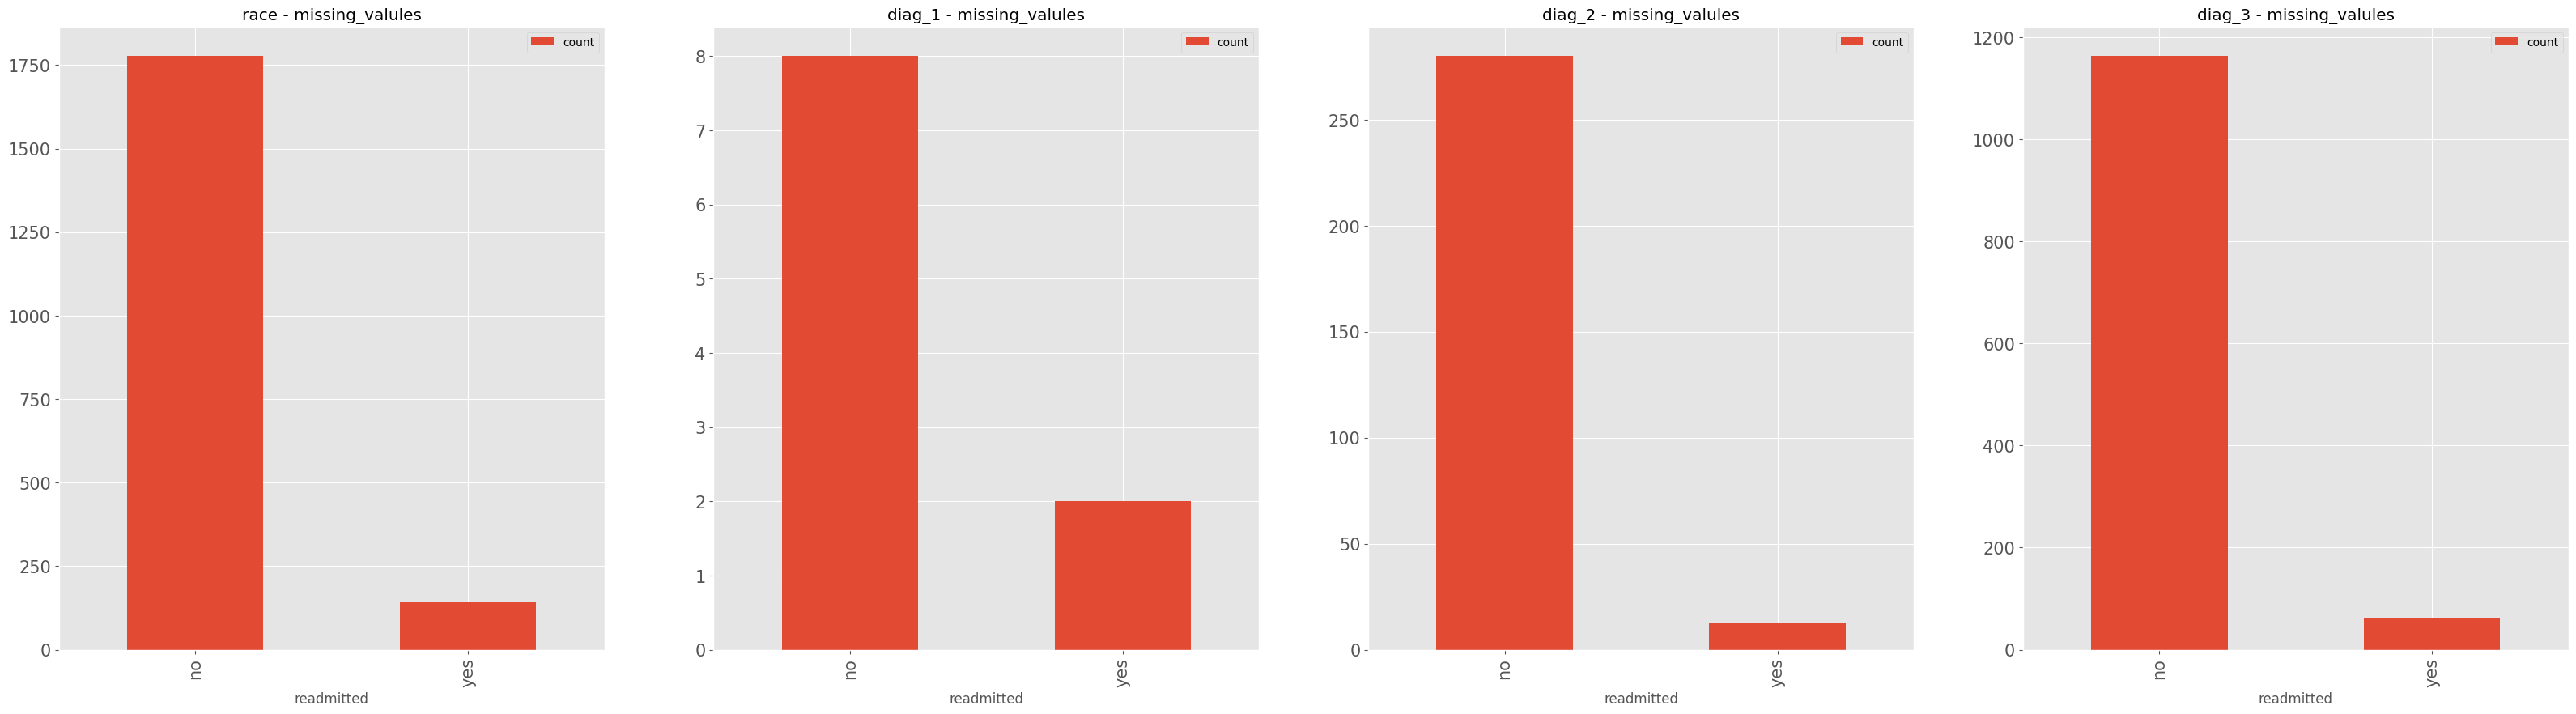

In [31]:
###############################################################
# 6. Bar Plots of the distribution of the label column 'readmitted' for all features that have missing values (NaNs)
###############################################################
# Lets us look at teh distribution of the labels and other columns for the missing values

df_InstanceClean.groupBy('readmitted').count().show()
df1 = df_InstanceClean.select('readmitted').where(func.col('race') == 'NaN').groupBy('readmitted').count().toPandas()
df2 = df_InstanceClean.select('readmitted').where(func.col('diag_1') == 'NaN').groupBy('readmitted').count().toPandas()
df3 = df_InstanceClean.select('readmitted').where(func.col('diag_2') == 'NaN').groupBy('readmitted').count().toPandas()
df4 = df_InstanceClean.select('readmitted').where(func.col('diag_3') == 'NaN').groupBy('readmitted').count().toPandas()

# df1.head()
# # medical_specialty
vizualize([df1,df2,df3,df4], rows=1, columns=4, figsize=(40, 10),
          xlabels=['readmitted','readmitted','readmitted','readmitted'],
          ylabels=['count','count','count','count'],
          titles=['race - missing_valules','diag_1 - missing_valules','diag_2 - missing_valules','diag_3 - missing_valules'],
          plot='bar')

In [32]:
###############################################################
# 7. Check if values are missing at random or there exists some relationship.
#    See How many missing value intersect between the columns race, diag_2, and diag_3
#    see if they are arbitararily missing or not
###############################################################

# Instances with NaN for diag_1, diag_1 has only 10 missing value, and based on the desnity of readmitted =yes and readmitted=no the NaN are distributed uniformly
print ('Number of instances having missing values for diag_1')
encID_diag1_Nan = df_InstanceClean.select('encounter_id').where((func.col('diag_1') == 'NaN')).toPandas()
encID_diag1_Nan = np.array(encID_diag1_Nan['encounter_id'])
print (len(encID_diag1_Nan))

# ------------------------------------------------------------------------------

# Instances with NaN for both race and diag_2
print ('Number of instances having missing values for both race and diag_2')
encID_racediag2_Nan = df_InstanceClean.select('encounter_id').where((func.col('race') == 'NaN') & (func.col('diag_2') == 'NaN')).toPandas()
encID_racediag2_Nan = np.array(encID_racediag2_Nan['encounter_id'])
print (len(encID_racediag2_Nan))

# ------------------------------------------------------------------------------

# Instances with NaN for both race and diag_3
print ('Number of instances having missing values for both race and diag_2')
encID_racediag3_Nan = df_InstanceClean.select('encounter_id').where((func.col('race') == 'NaN') & (func.col('diag_3') == 'NaN')).toPandas()
encID_racediag3_Nan = np.array(encID_racediag3_Nan['encounter_id'])
print (len(encID_racediag3_Nan))

# ------------------------------------------------------------------------------

# Instances with NaN for both race and diag_2 and diag_3
print ('Number of instances having missing values for both diag_2 and diag_3')
# Out of 293 missing values for diag_2 243 are missing in both diag_2 and diag_3
encID_diag2diag3_Nan = df_InstanceClean.select('encounter_id').where((func.col('diag_2') == 'NaN') & (func.col('diag_3') == 'NaN')).toPandas()
encID_diag2diag3_Nan = np.array(encID_diag2diag3_Nan['encounter_id'])
print (len(encID_diag2diag3_Nan))

# ------------------------------------------------------------------------------

# Instances with NaN for both race and diag2 and diag_3
print ('Number of instances having missing values for both race and diag_2 and diag_3')
encID_racediag2diag3_Nan = df_InstanceClean.select('encounter_id').where((func.col('race') == 'NaN') & (func.col('diag_2') == 'NaN') & (func.col('diag_3') == 'NaN')).toPandas()
encID_racediag2diag3_Nan = np.array(encID_racediag2diag3_Nan['encounter_id'])
print (len(encID_racediag2diag3_Nan))

Number of instances having missing values for diag_1
10
Number of instances having missing values for both race and diag_2
19
Number of instances having missing values for both race and diag_2
67
Number of instances having missing values for both diag_2 and diag_3
243
Number of instances having missing values for both race and diag_2 and diag_3
14


In [33]:
###############################################################
# 1. Sparse Feature Removal and update the list of Nominal features
# 2. Instance-based cleaning: Impute Missing values with proper categories
###############################################################

# 1. As we can see that Weight is sparse with 96% missing and payer_code is a non-important feature so we remove them
df_InstanceClean1 = df_InstanceClean.drop(*['weight', 'payer_code'])
nominalFeature = [feature for feature in nominalFeature if feature not in ['weight', 'payer_code']]
print ('The new set (clean set) of nominal features are: ')
print (nominalFeature)
print ('')

# --------------------------------------------------------------------------------------------------------------


# 2. The feature 'diag_1 has only 10 missing values, so its a good idea to get rid of those instances'
# print (list(encID_diag1_Nan))
# encID_diag1_Nan = np.array(encID_diag1_Nan)
# encID_diag1_Nan = [4342662, 7599132, 8927178, 10122996, 20095914, 117010956, 163172034, 164326842, 169067490, 273014598]
df_InstanceClean1 = (df_InstanceClean1
                       .where(func.col('encounter_id').isin(encID_diag1_Nan.tolist()) == False)
                   )  # Dont select the NaN's

print ("The new count of instances after removing NaN's of diag_1 and replacing all other NaN's with 'missing' is :")
print (df_InstanceClean1.count())
# diabeticCleanDF_NaN.show(5)


# # --------------------------------------------------------------------------------------------------------------


# 3. For Nominal Attributes replace all the Missing feature values as a category 'missing'
def cleanNull(value):
    if value == 'NaN':
        return str('missing')
    else: return value

upd_missing = func.udf(cleanNull, StringType())
for feature in nominalFeature:
    df_InstanceClean1 = df_InstanceClean1.withColumn(feature, upd_missing(feature))

# print ('')
# print (diabeticCleanDF_NaN.show(5))

The new set (clean set) of nominal features are: 
['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']

The new count of instances after removing NaN's of diag_1 and replacing all other NaN's with 'missing' is :
69963


In [34]:
###############################################################
# 3. Sanity Check : Summary statistics for Nominal Features after removing/replacing all the NaN.
###############################################################

# Check if their are still NaN's left in the dataset

statsNominal_NaN = statNominalfeatures(df_InstanceClean1)

with pd.option_context('display.max_columns', None):
    display(statsNominal_NaN)

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
total,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963,69963
numUnqCat,6,3,10,8,21,17,71,694,724,757,4,4,4,4,4,4,4,2,4,4,2,4,4,3,4,2,2,1,1,4,4,2,1,2,2,2,2,2
catDistPrcntg,"[74.74, 1.64, 18.04, 2.74, 2.14, 0.7]","[53.21, 0.0, 46.79]","[53.21, 0.0, 46.79]","[0.03, 19.7, 0.42, 4.41, 6.45, 50.69, 0.01, 18.3]","[0.03, 19.7, 0.42, 4.41, 6.45, 50.69, 0.01, 18.3]","[0.03, 19.7, 0.42, 4.41, 6.45, 50.69, 0.01, 18.3]","[0.03, 19.7, 0.42, 4.41, 6.45, 50.69, 0.01, 18.3]","[0.03, 19.7, 0.42, 4.41, 6.45, 50.69, 0.01, 18.3]","[0.03, 19.7, 0.42, 4.41, 6.45, 50.69, 0.01, 18.3]","[0.03, 19.7, 0.42, 4.41, 6.45, 50.69, 0.01, 18.3]","[95.21, 1.02, 2.43, 1.34]","[81.64, 8.91, 5.35, 4.1]","[19.48, 1.19, 78.7, 0.62]","[1.17, 0.1, 98.69, 0.04]","[0.67, 0.02, 99.3, 0.01]","[0.09, 0.01, 99.9, 0.0]","[4.76, 0.33, 94.72, 0.19]","[0.0, 100.0]","[11.52, 0.82, 87.13, 0.53]","[9.64, 0.88, 88.89, 0.6]","[0.02, 99.98]","[7.15, 0.25, 92.48, 0.12]","[6.36, 0.19, 93.34, 0.11]","[0.27, 0.01, 99.71]","[0.03, 0.0, 99.97, 0.0]","[0.0, 100.0]","[0.04, 99.96]",[100.0],[100.0],"[30.89, 9.69, 48.96, 10.46]","[0.69, 0.01, 99.29, 0.01]","[0.01, 99.99]",[100.0],"[0.0, 100.0]","[0.0, 100.0]","[45.0, 55.0]","[23.84, 76.16]","[91.03, 8.97]"
chi_pValue,0.00231,0.728106,0.0,0.00902,0.0,0.215287,0.0,0.0,0.0,0.0,0.071533,0.063118,0.002477,0.000038,0.428961,0.556694,0.236235,0.753603,0.003191,0.623901,0.655993,0.364186,0.696848,0.280183,0.928865,0.586658,0.27991,1.0,1.0,0.0,0.437191,0.406246,1.0,0.657104,0.753603,0.000103,0.0,0.0
NaNs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
% NaNs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
###############################################################
# 4. Using the above summary Statistics for Nominal Features find non-important Features.
###############################################################

def featureSelection(chi_sq=None):
    badFeatures = []
    for nominalFeature in statsNominal.columns:
        if np.max(statsNominal.loc['catDistPrcntg',nominalFeature]) == 100:
            badFeatures.append(nominalFeature)
        if chi_sq:
            if np.max(statsNominal.loc['chi_pValue',nominalFeature]) > chi_sq:
                badFeatures.append(nominalFeature)
    return badFeatures #, diabeticCleanDF.drop(*badFeatures)


badNominalFeatures1 = featureSelection(chi_sq=None)
badNominalFeatures2 = featureSelection(chi_sq=0.10)

print ('Features to be removed from dataset based on the category distribution are: ........................')
print (badNominalFeatures1)
print ('')
print ('Features to be removed from dataset based on the chiSquare statistics are: .........................')
print (badNominalFeatures2)

Features to be removed from dataset based on the category distribution are: ........................
['acetohexamide', 'troglitazone', 'examide', 'citoglipton', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']

Features to be removed from dataset based on the chiSquare statistics are: .........................
['gender', 'admission_source_id', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'acetohexamide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'troglitazone', 'tolazamide', 'examide', 'examide', 'citoglipton', 'citoglipton', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'metformin-pioglitazone']


In [36]:
#############################################
# 5. Update the list of Nominal Features.
#############################################
nominalFeatureF1 = [feature for feature in nominalFeature if feature not in badNominalFeatures1]
nominalFeatureF2 = [feature for feature in nominalFeature if feature not in badNominalFeatures2]

print ('The new Nominal feature F1 set is : ')
print (nominalFeatureF1)
print ('')
print ('The new Nominal feature F2 set is : ')
print (nominalFeatureF2)

The new Nominal feature F1 set is : 
['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'change', 'diabetesMed', 'readmitted']

The new Nominal feature F2 set is : 
['race', 'age', 'admission_type_id', 'discharge_disposition_id', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'glipizide', 'insulin', 'change', 'diabetesMed', 'readmitted']


+---------+-----+
|A1Cresult|count|
+---------+-----+
|     None|57121|
|       >8| 6237|
|     Norm| 3740|
|       >7| 2865|
+---------+-----+



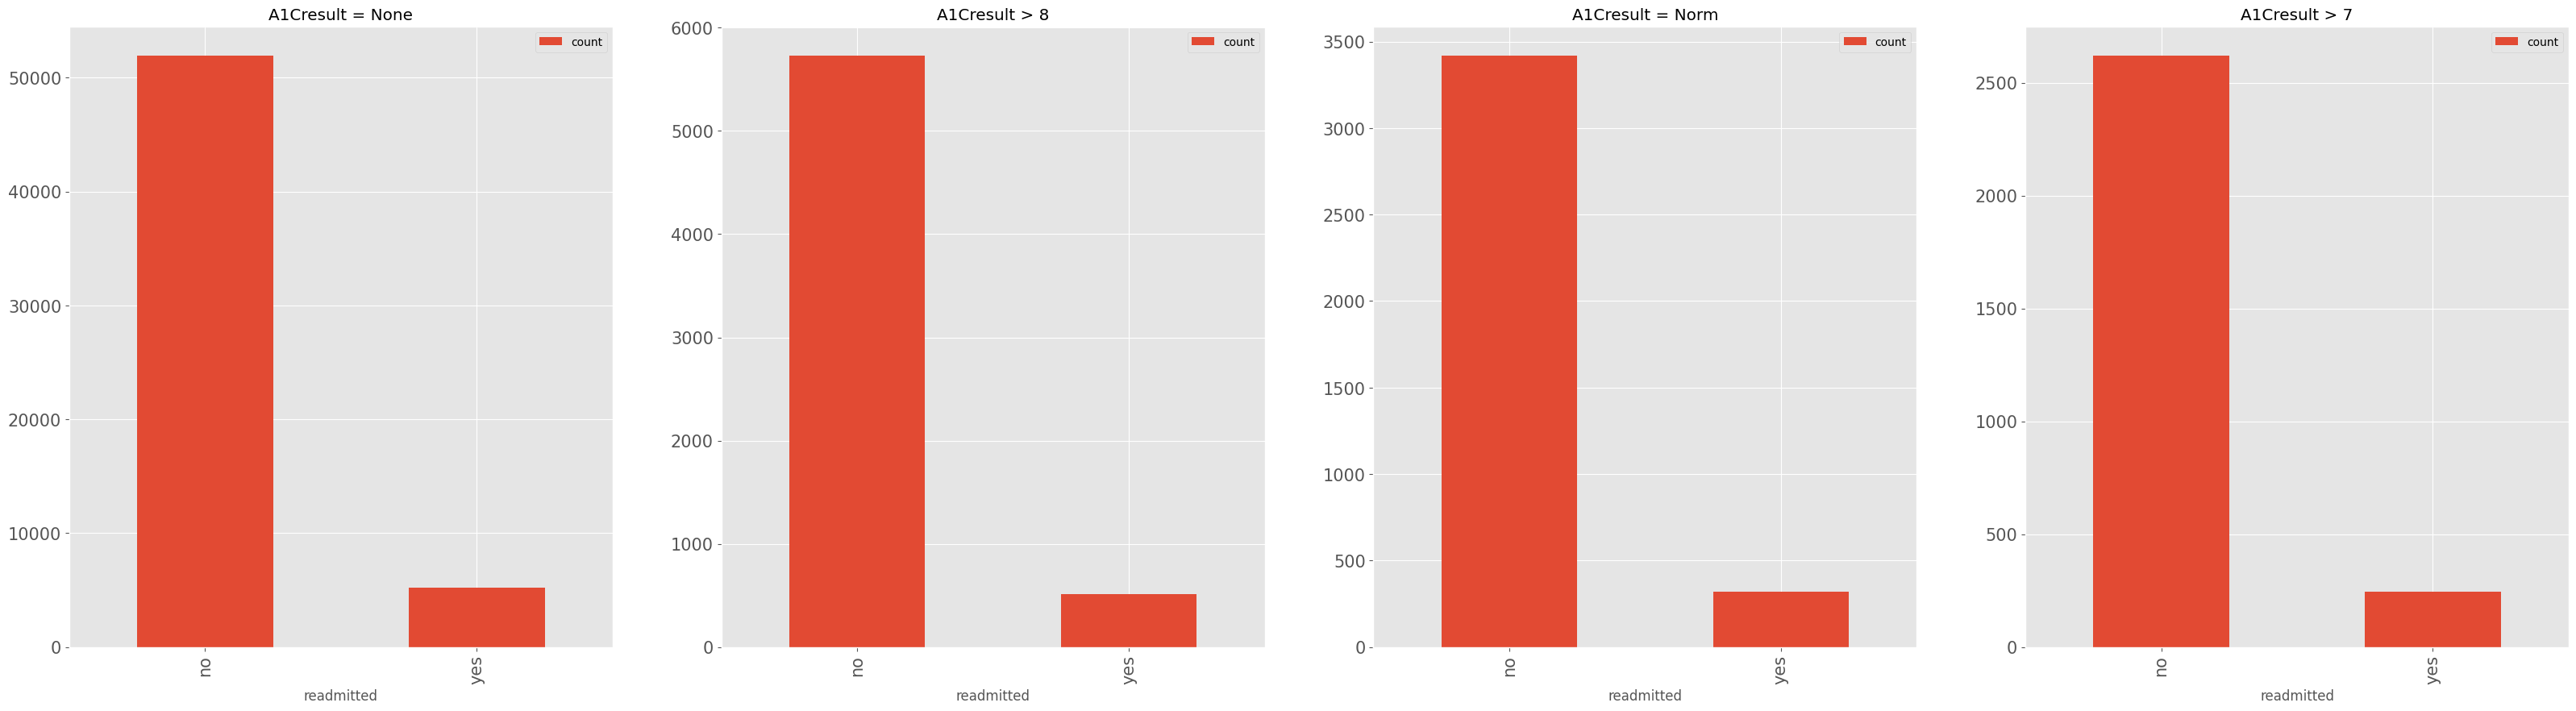

In [37]:
###############################################################
# 3. Bar Plots of the distribution of the label column 'readmitted'
#    for all the categorical values of feature 'A1Cresult'
###############################################################

df_InstanceClean1.groupBy('A1Cresult').count().show()  # --> None, >8, Norm, >7

A1C_none = df_InstanceClean1.select('readmitted').where(func.col('A1Cresult') == 'None').groupBy('readmitted').count().toPandas()
A1C_g8 = df_InstanceClean1.select('readmitted').where(func.col('A1Cresult') == '>8').groupBy('readmitted').count().toPandas()
A1C_norm = df_InstanceClean1.select('readmitted').where(func.col('A1Cresult') == 'Norm').groupBy('readmitted').count().toPandas()
A1C_g7 = df_InstanceClean1.select('readmitted').where(func.col('A1Cresult') == '>7').groupBy('readmitted').count().toPandas()

title_arr=['A1Cresult = None','A1Cresult > 8','A1Cresult = Norm','A1Cresult > 7']
vizualize([A1C_none,A1C_g8,A1C_norm,A1C_g7], rows=1, columns=4, figsize=(40, 10),
          xlabels=['readmitted','readmitted','readmitted','readmitted'],
          ylabels=['count','count','count','count'],
          titles=title_arr,
          plot='bar')

+------+-----+
|change|count|
+------+-----+
|    Ch|31486|
|    No|38477|
+------+-----+

+-----------+-----+
|diabetesMed|count|
+-----------+-----+
|         No|16678|
|        Yes|53285|
+-----------+-----+



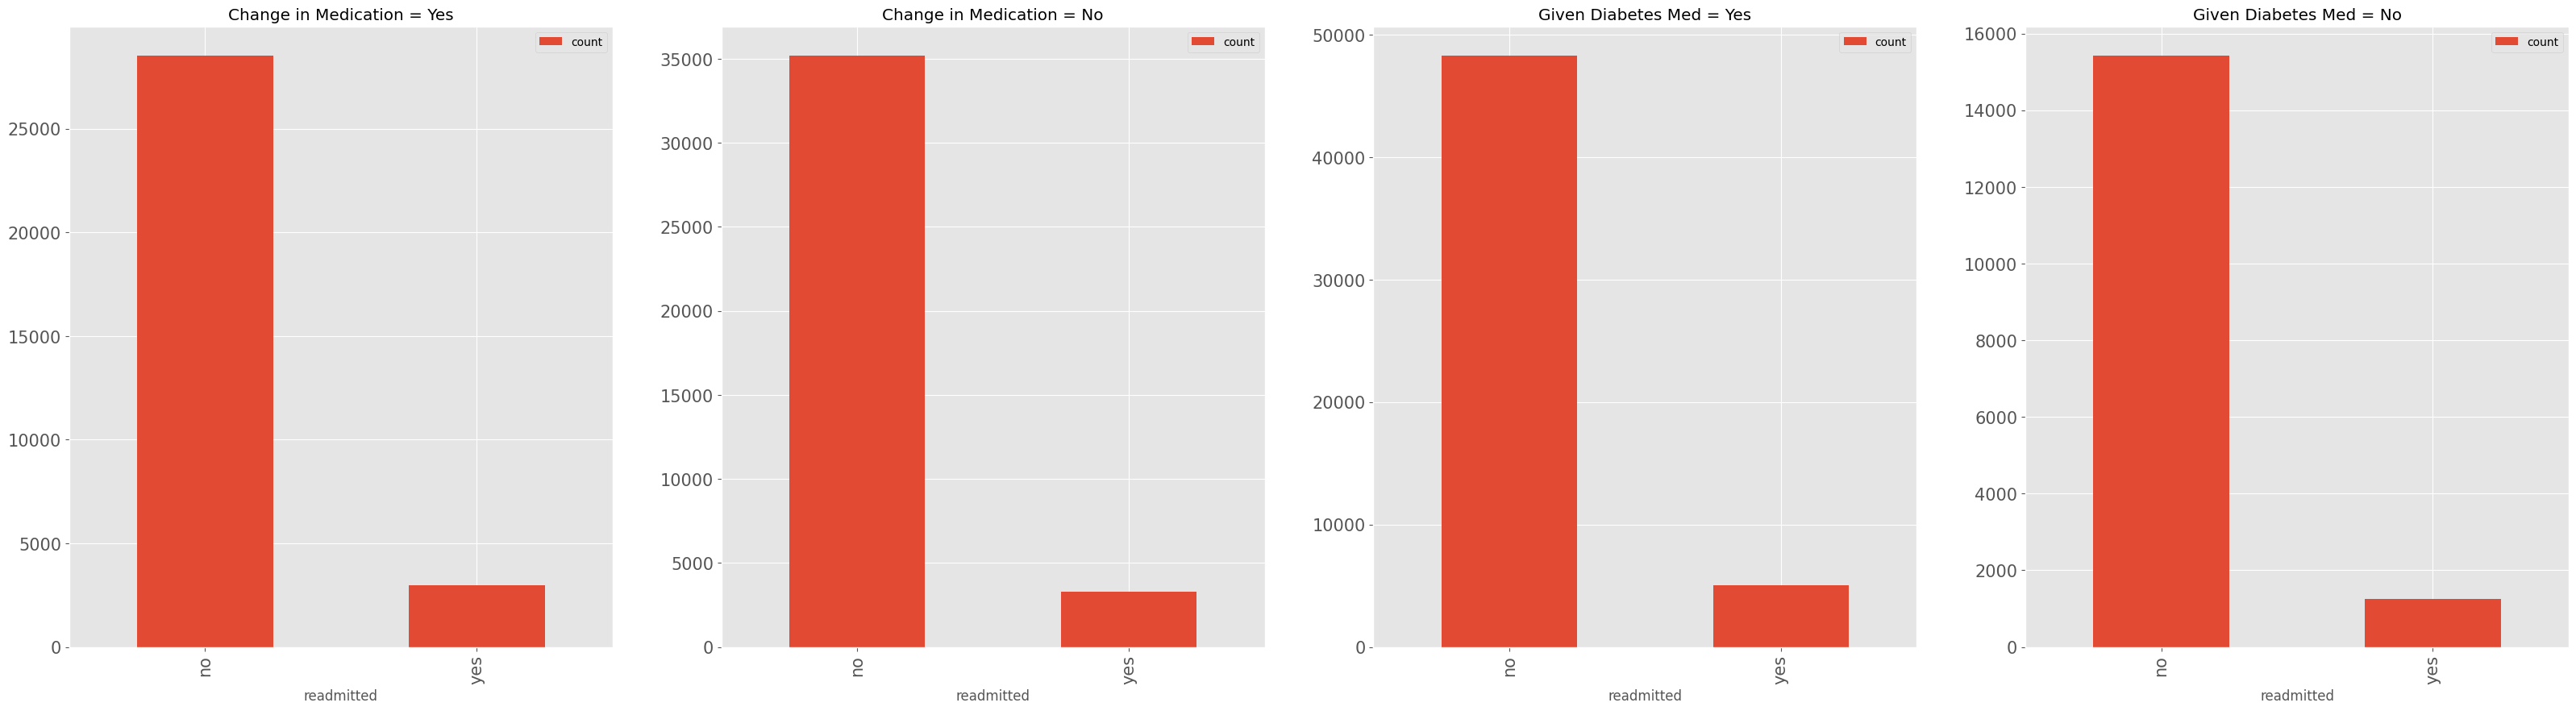

In [38]:
###############################################################
# 4. Bar Plots of the distribution of the label column 'readmitted'
#    for all the categorical values of feature 'change'
# 5. Bar Plots of the distribution of the label column 'readmitted'
#    for all the categorical values of feature 'diabetesMed'
###############################################################

# Lets us look at teh distribution of the labels and other columns for the missing values

df_InstanceClean1.groupBy('change').count().show()
df_InstanceClean1.groupBy('diabetesMed').count().show()

change_ch = df_InstanceClean1.select('readmitted').where(func.col('change') == 'Ch').groupBy('readmitted').count().toPandas()
change_no = df_InstanceClean1.select('readmitted').where(func.col('change') == 'No').groupBy('readmitted').count().toPandas()

diabetesMed_yes = df_InstanceClean1.select('readmitted').where(func.col('diabetesMed') == 'Yes').groupBy('readmitted').count().toPandas()
diabetesMed_no = df_InstanceClean1.select('readmitted').where(func.col('diabetesMed') == 'No').groupBy('readmitted').count().toPandas()


title_arr=['Change in Medication = Yes','Change in Medication = No','Given Diabetes Med = Yes','Given Diabetes Med = No']
vizualize([change_ch,change_no,diabetesMed_yes,diabetesMed_no], rows=1, columns=4, figsize=(40, 10),
          xlabels=['readmitted','readmitted','readmitted','readmitted'],
          ylabels=['count','count','count','count'],
          titles=title_arr,
          plot='bar')

In [39]:
# Common functions for taking a sample from teh original dataset and plotting the numerical features.

class DataFramePlots():

    def __init__(self):
#         random.seed(42351)
        pass

    def sampleDataFrame(self, dataFrameIN, featureSet):
        pdDF = dataFrameIN.select(*featureSet).toPandas()
        dfINX = random.sample(list(pdDF.index), 7000)
        pdDFSample = pdDF.loc[dfINX]
        return pdDFSample

    def createDataFrameArr(self,dataFrameIN, featureSet):
        dataFramArray = []
        for featureName in featureSet:
            pdDF = dataFrameIN.select(*[featureName]).toPandas()
            dfINX = random.sample(list(pdDF.index), 7000)
            pdDFSample = pdDF.loc[dfINX]
            dataFramArray.append(pdDFSample)
        return dataFramArray

In [40]:
#############################################
# 1. Get the list of Numeric Features.
#############################################

numericFeature = [feature.name for feature in df_InstanceClean1.schema.fields if str(feature.dataType)=='IntegerType']
print ('Numeric Features are: ', numericFeature)

Numeric Features are:  ['encounter_id', 'patient_nbr', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']


In [41]:
from pyspark.mllib.stat import Statistics
import pandas as pd
import numpy as np
from functools import reduce


In [42]:
!sudo apt-get purge openjdk-\* icedtea-\* icedtea6-\*

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'openjdk-11-jdk' for glob 'openjdk-*'
Note, selecting 'openjdk-11-jre' for glob 'openjdk-*'
Note, selecting 'openjdk-11-jre-headless' for glob 'openjdk-*'
Note, selecting 'openjdk-19-jre-headless' for glob 'openjdk-*'
Note, selecting 'openjdk-8-jre-zero' for glob 'openjdk-*'
Note, selecting 'openjdk-11-jdk-headless' for glob 'openjdk-*'
Note, selecting 'openjdk-21-jdk-headless' for glob 'openjdk-*'
Note, selecting 'openjdk-19-jdk-headless' for glob 'openjdk-*'
Note, selecting 'openjdk-21-demo' for glob 'openjdk-*'
Note, selecting 'openjdk-18-jdk-headless' for glob 'openjdk-*'
Note, selecting 'openjdk-17-dbg' for glob 'openjdk-*'
Note, selecting 'openjdk-17-doc' for glob 'openjdk-*'
Note, selecting 'openjdk-18-dbg' for glob 'openjdk-*'
Note, selecting 'openjdk-17-jdk' for glob 'openjdk-*'
Note, selecting 'openjdk-18-doc' for glob 'openjdk-*'
Note, selecting 'openjdk-17-jre' f

In [43]:
!sudo apt install openjdk-8-jre-headless

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-8-jre-headless is already the newest version (8u392-ga-1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 81 not upgraded.


In [44]:
!export JAVA_HOME='/usr/lib/jvm/java-8-openjdk-amd64'
!export PATH=$JAVA_HOME/bin:$PATH
!export SPARK_HOME='/path/to/spark-2.x.x-bin-hadoop2.7'
!export PATH=$SPARK_HOME/bin:$PATH

In [45]:
!export JAVA_HOME='/usr/lib/jvm/java-8-openjdk-amd64'
!export PYSPARK_PYTHON=python3

In [46]:
!export SPARK_HOME='/path/to/spark-2.x.x-bin-hadoop2.7'
!export PATH=$SPARK_HOME/bin:$PATH
!export SPARK_CONF_DIR=$SPARK_HOME/conf

In [47]:
!source ~/.bashrc

In [49]:
###############################################################
# 3. Based on the summary statictics find the bad Numeric features and update the list of numericFeatures
###############################################################

# The columns encounter_id and patient_nbr seems like a primary key column, We remove patient_nbr but keep 'encounter_id' and treat it as a ID column
df_InstanceClean1 = df_InstanceClean1.drop('patient_nbr')
badNumericFeature = ['patient_nbr', 'encounter_id']
numericFeature = [feature for feature in numericFeature if feature not in badNumericFeature]

print ('The new set of Numeric feature is : ')
print (numericFeature)

The new set of Numeric feature is : 
['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']


In [50]:
from pandas.plotting import scatter_matrix

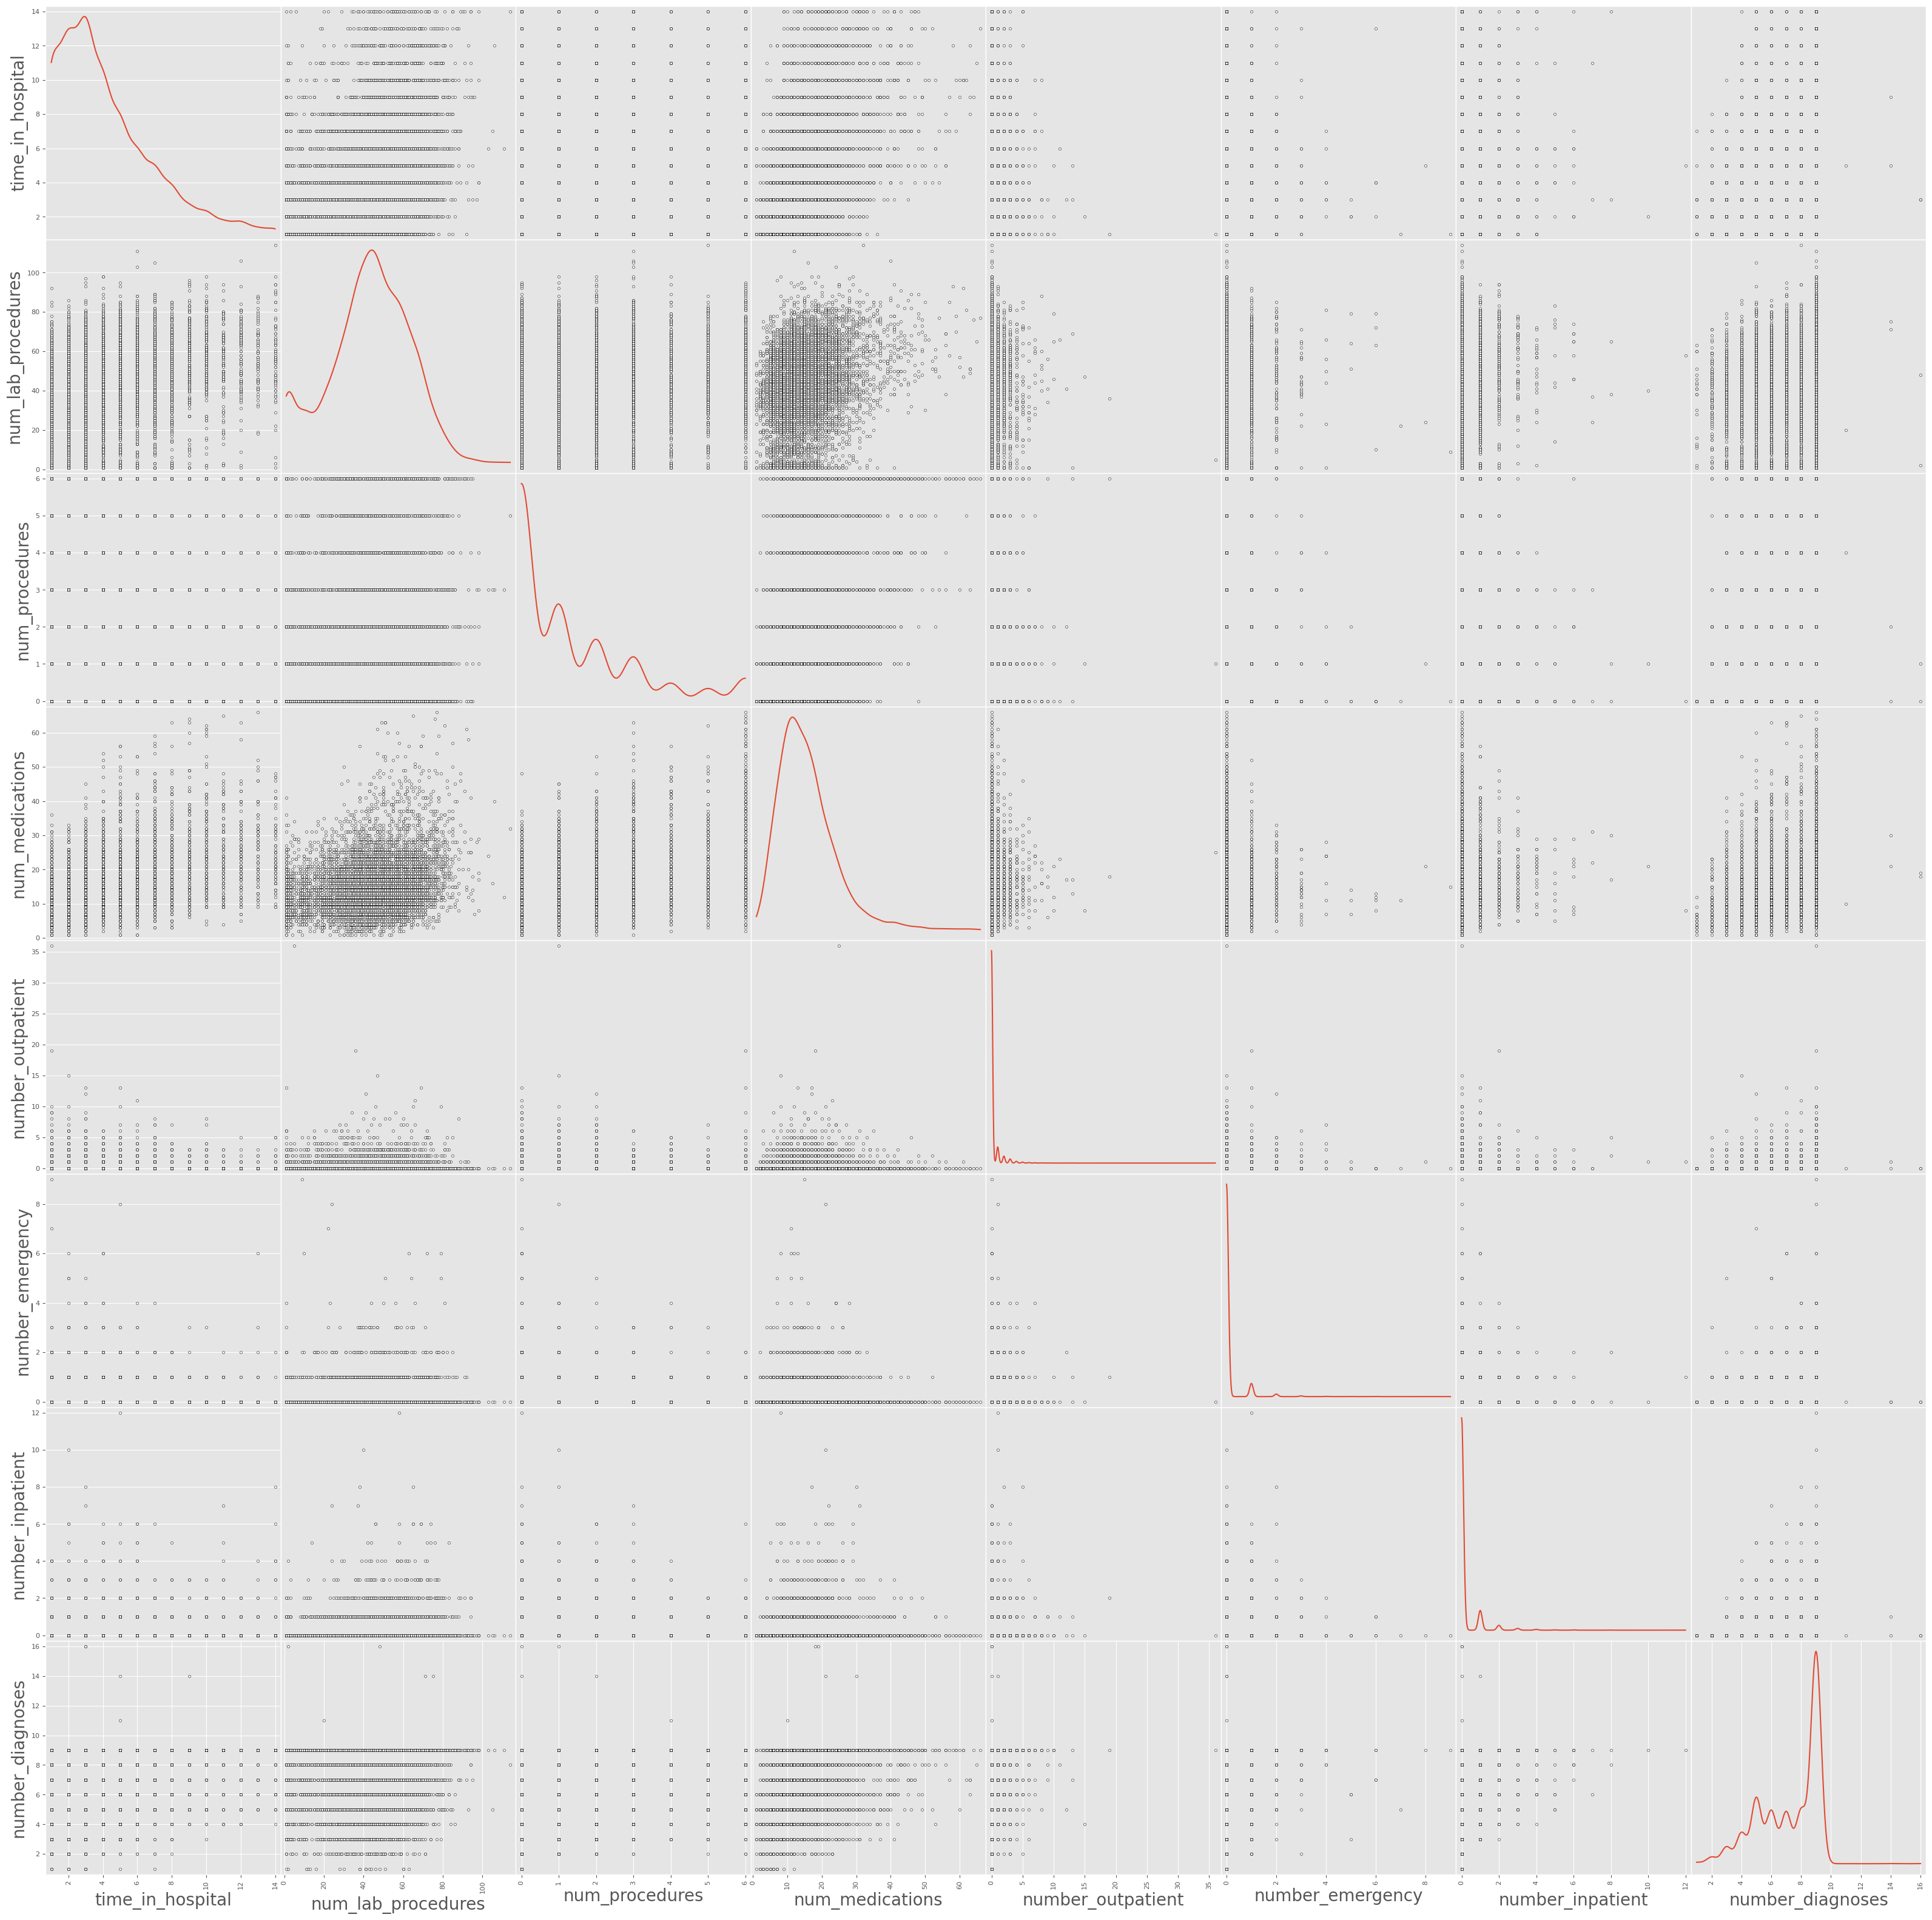

In [51]:
###############################################################
# 1. Vizualize scatter-plots matrix for the sampled dataset for Numerical attributes
###############################################################


# Scattar Matrix of each Numeric columns with each other.
dataFrameNumericPD = DataFramePlots().sampleDataFrame(df_InstanceClean1, numericFeature)
plt.rcParams['axes.labelsize'] = 20
a = scatter_matrix(dataFrameNumericPD, alpha=0.7, diagonal='kde', figsize=(40, 40), facecolor='w', edgecolor='k')

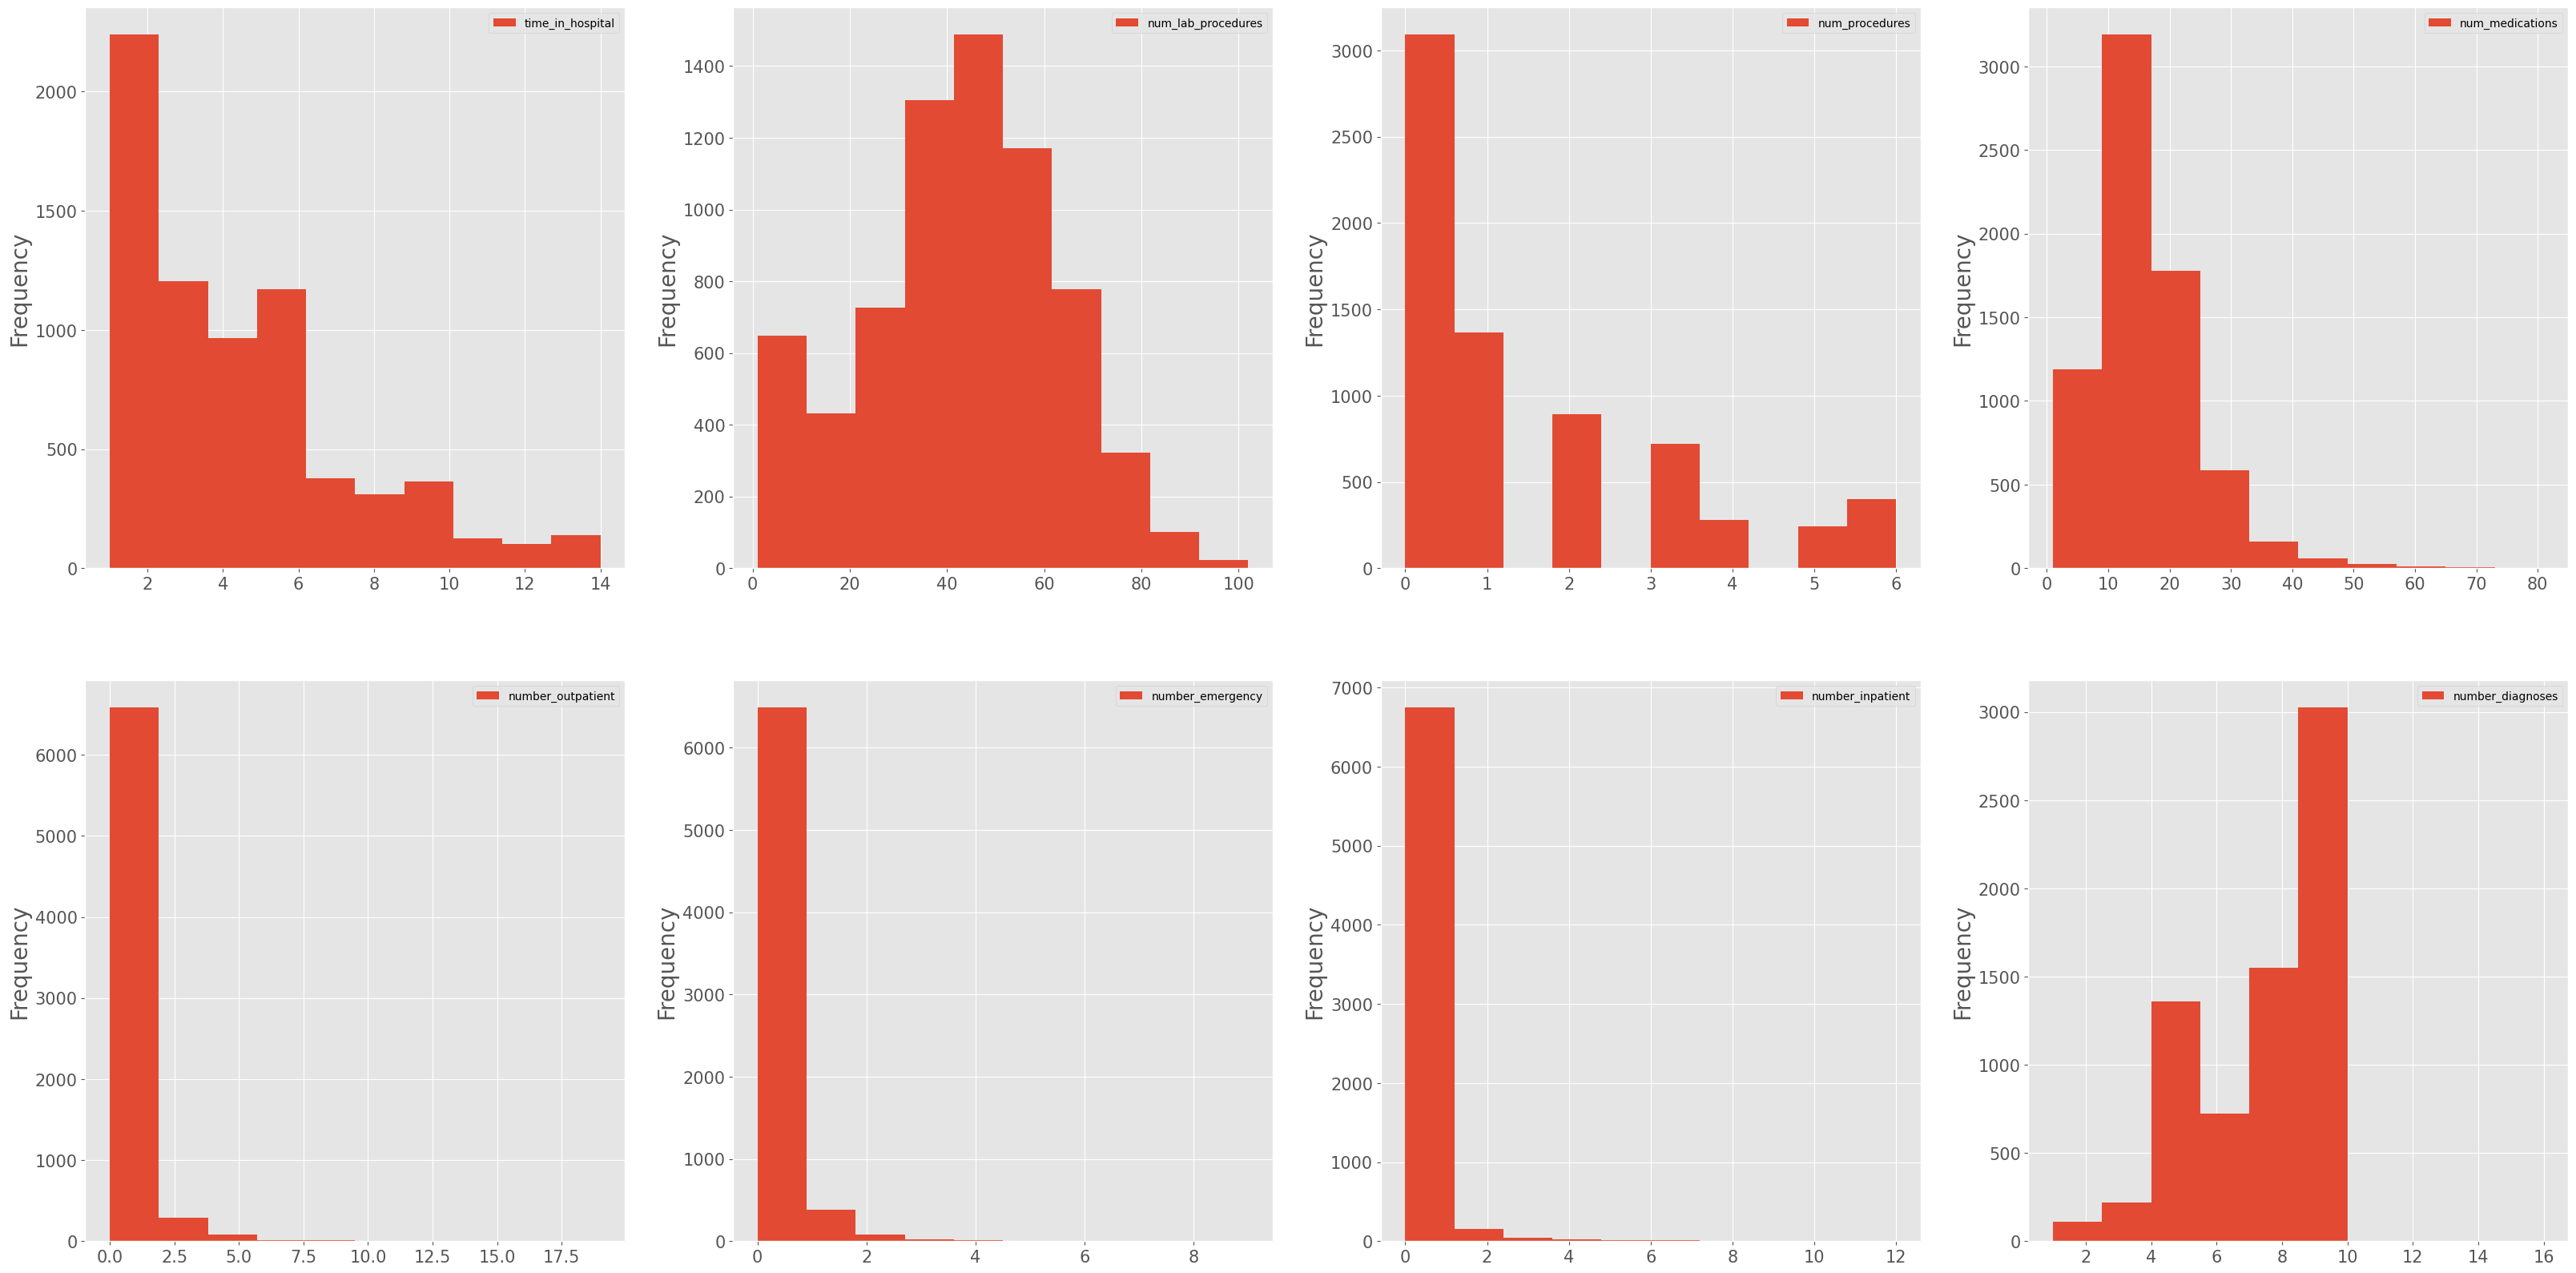

In [52]:
###############################################################
# 2. Vizualize histograms plots for the sampled dataset for Numerical attributes.
###############################################################
# Create separate dataframes Array for nominal and numeric attributes
dataFrameArrayNumeric = DataFramePlots().createDataFrameArr(df_InstanceClean1, numericFeature)
vizualize(dataFrameArrayNumeric, rows=2, columns=4, figsize=(40, 20), plot='hist')

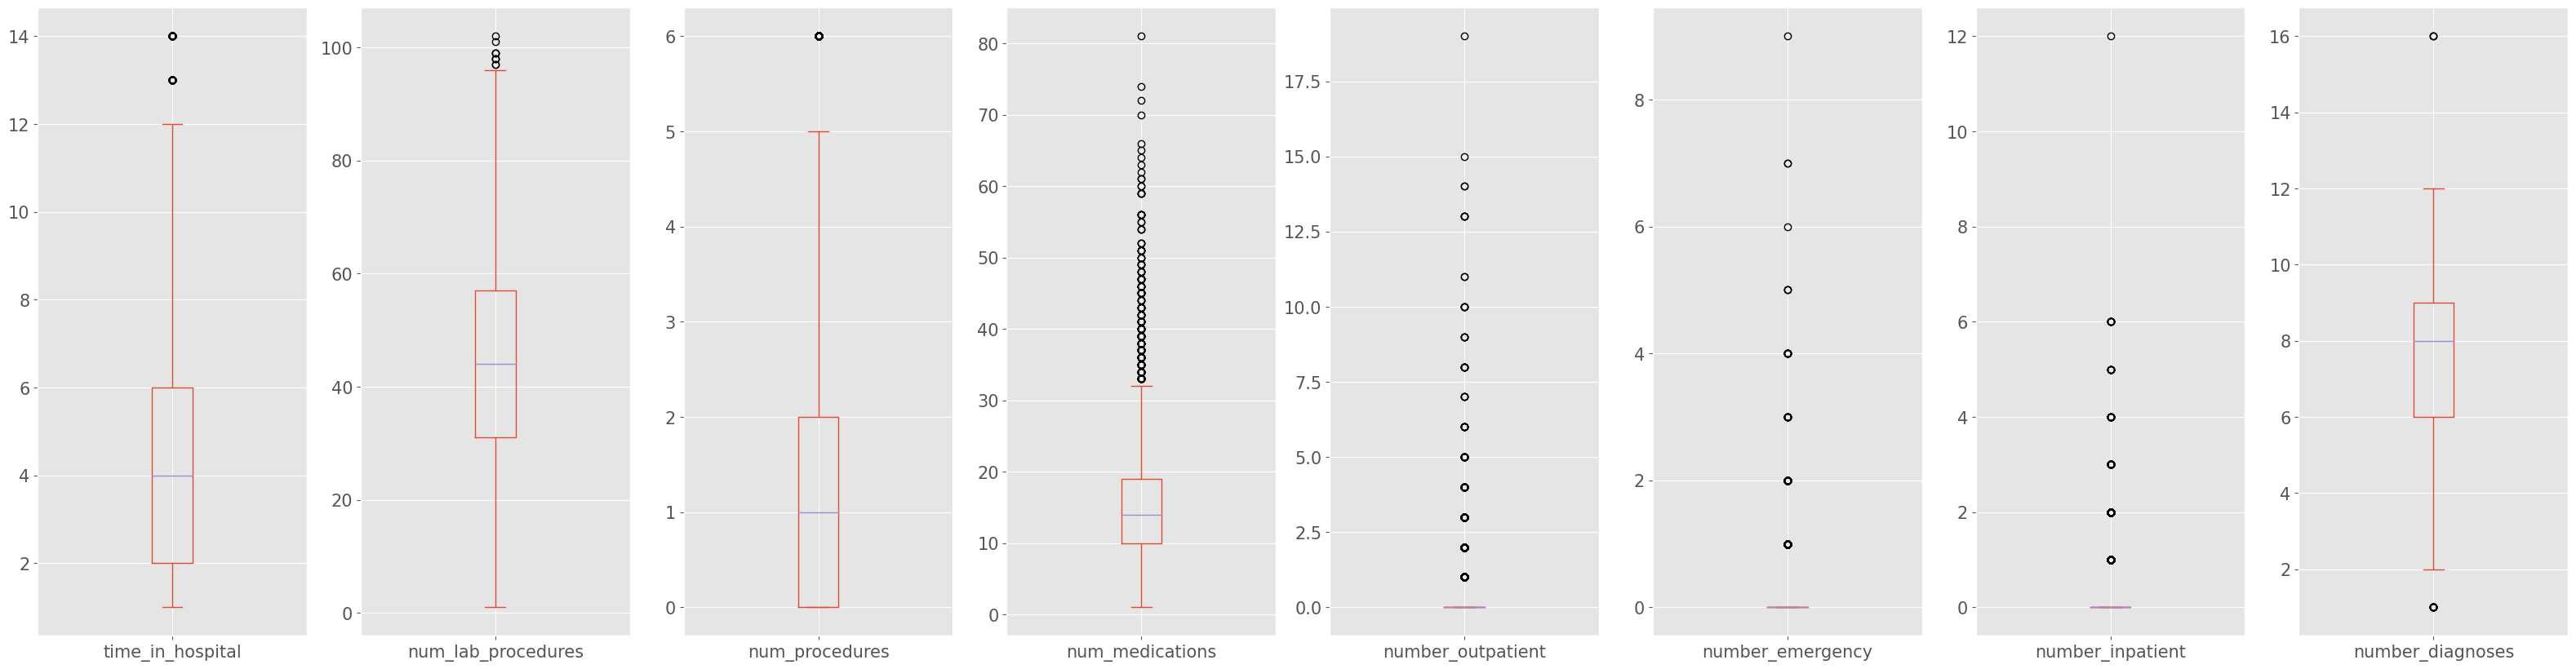

In [53]:

###############################################################
# 3. Vizualize box-plots for the sampled dataset for Numerical attributes.
###############################################################

vizualize(dataFrameArrayNumeric, rows=1, columns=8, figsize=(40, 10), plot='box')

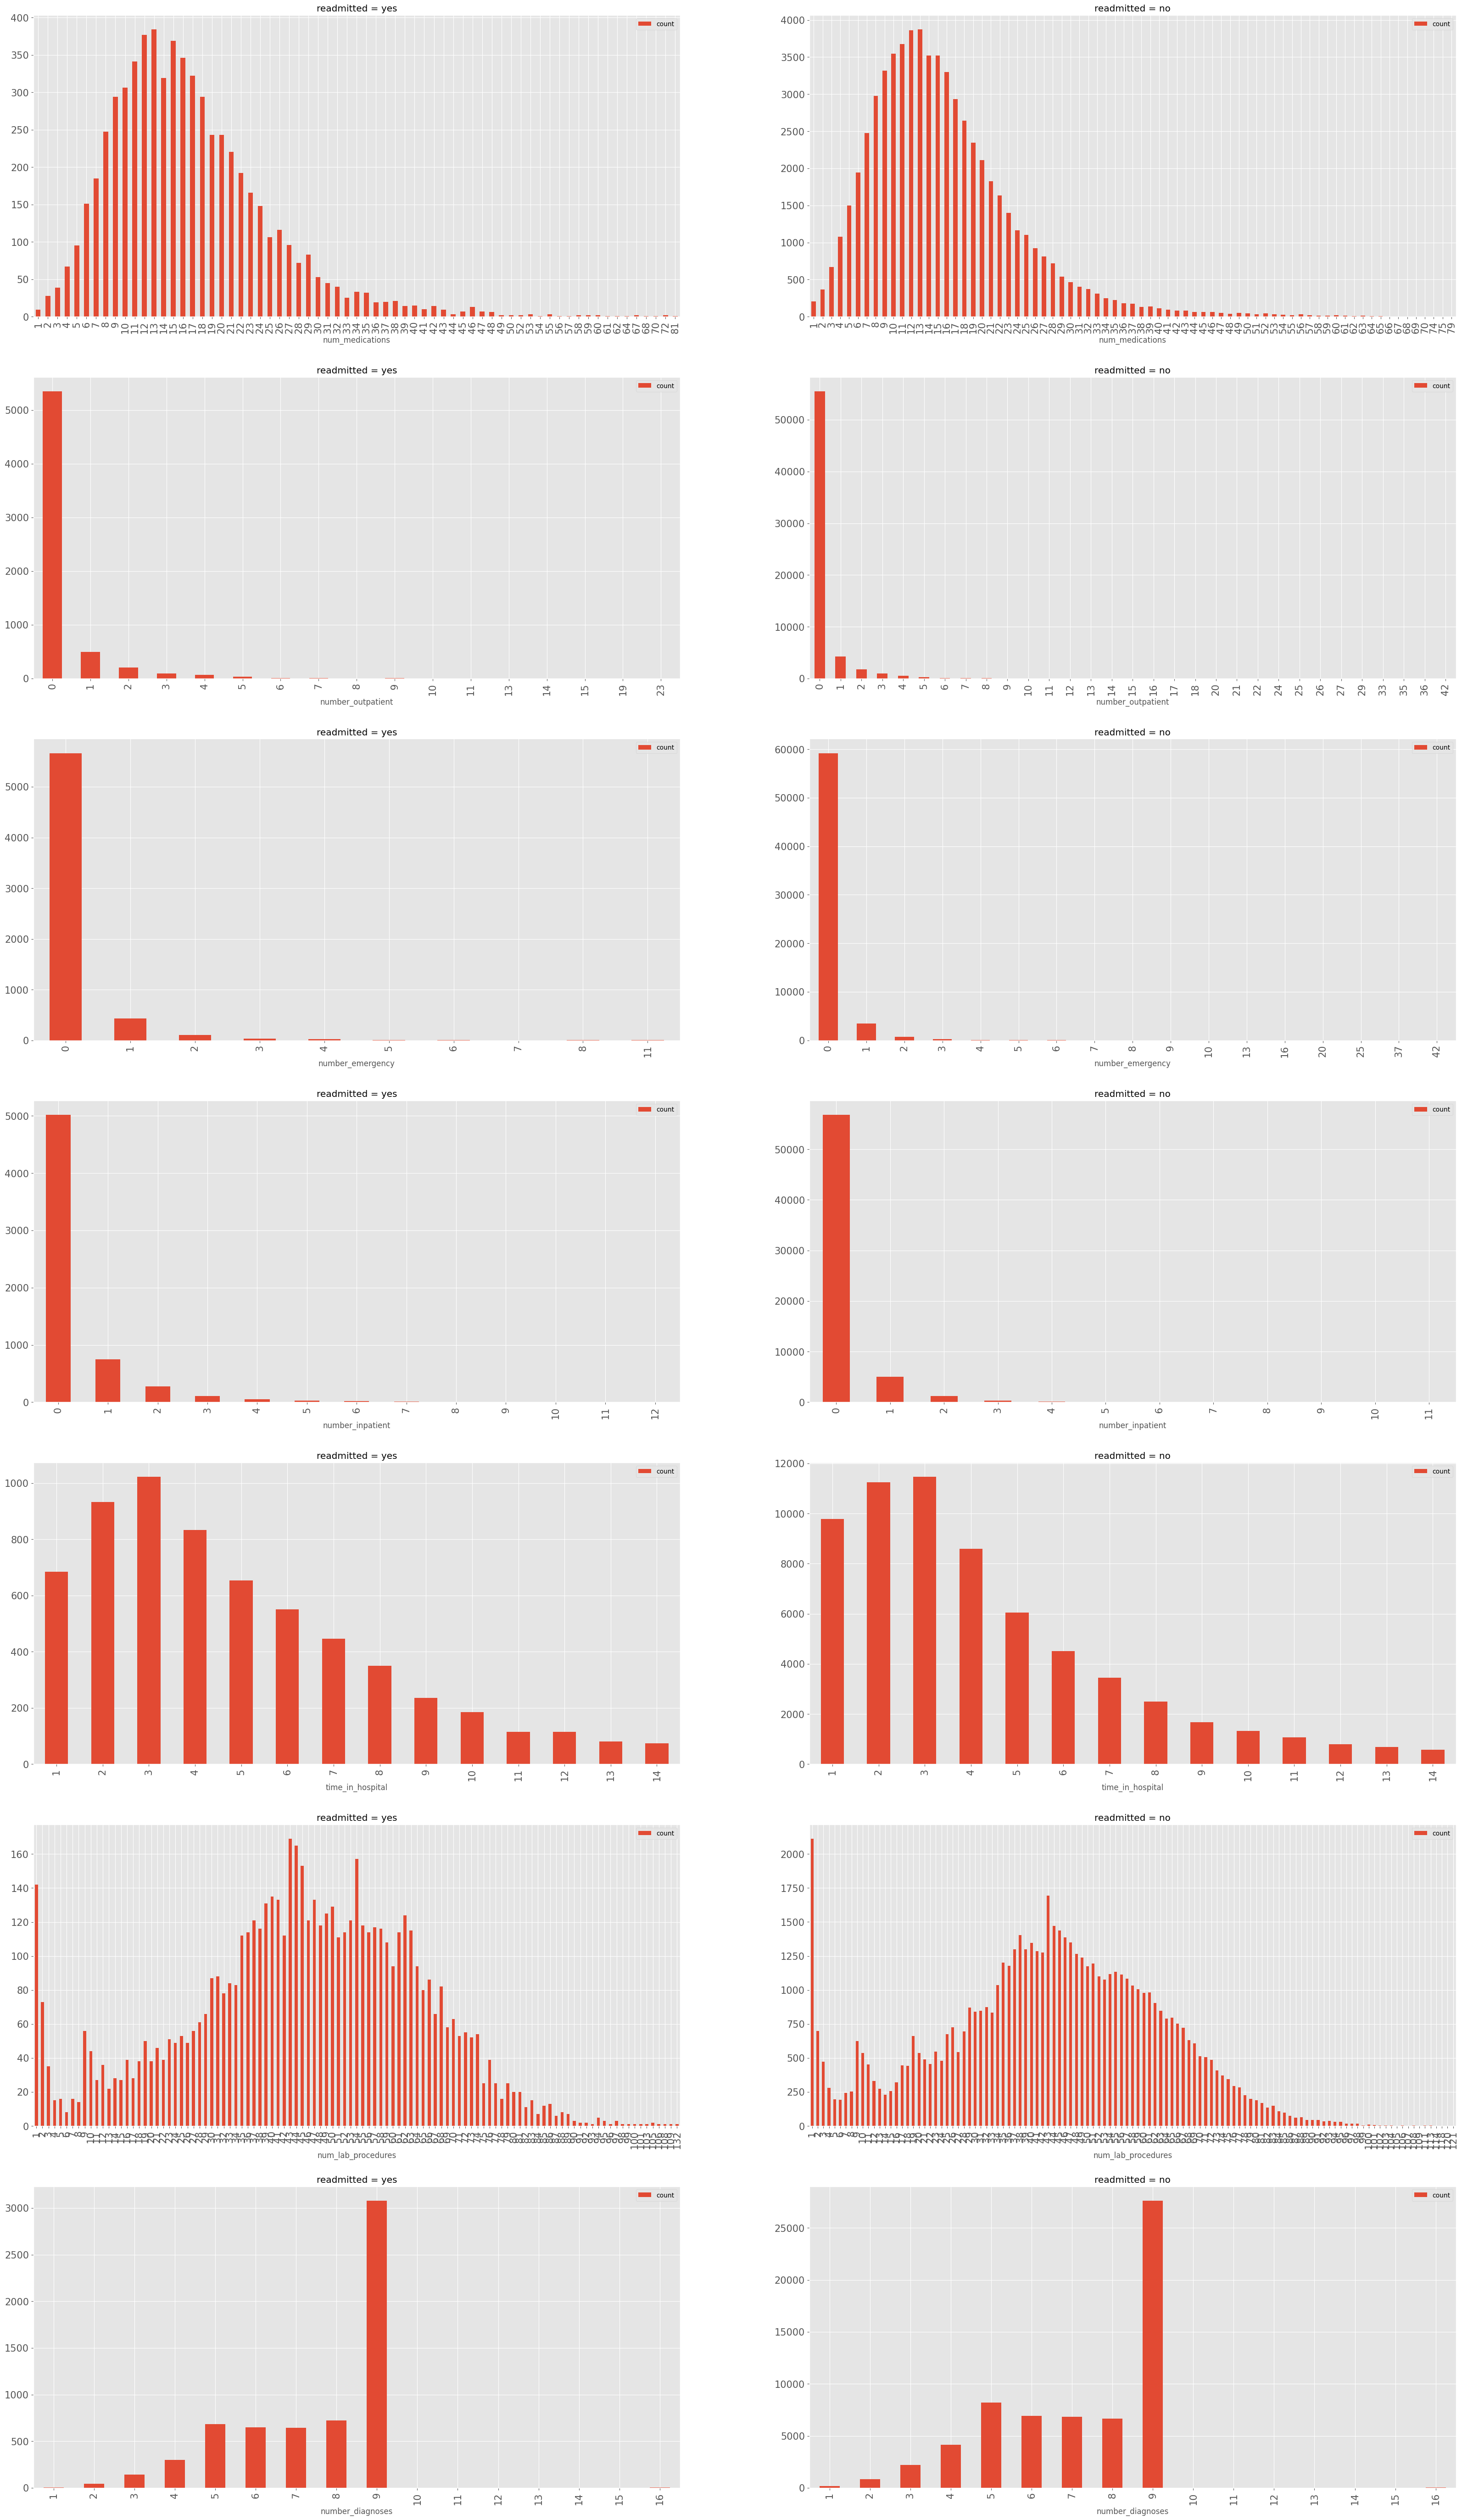

In [113]:
###############################################################
# 4. Vizualizing the distribution of the labels with some of the numerical features.
###############################################################

# Vizualizing the distribution of the class label "readmitted" with some of the numerical features.
# Since we would do a group by we can use all the instances for the plot, not just a small sample.
# Here we check the distribution of readmitted with num_medications, number_outpatient, number_emergency, number_inpatient

# diabeticCleanDF_NaN.groupBy('readmitted').count().show()
featureArr = ['num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient','time_in_hospital', 'num_lab_procedures', 'number_diagnoses']
labelsArr = ['yes', 'no']
dataframeArr = []
xlabels = []
ylabels = []
titles = []

for feature in featureArr:
    for labels in labelsArr:
        df = (df_InstanceClean1.select(feature).where(func.col('readmitted')==labels).groupBy(feature).count().orderBy(feature).toPandas())
        dataframeArr.append(df)
        xlabels.append(feature)
        ylabels.append('count')
        titles.append('readmitted = ' + labels)

vizualize(dataframeArr, rows=len(featureArr), columns=len(labelsArr), figsize=(40,len(featureArr)*10), xlabels=xlabels, ylabels=ylabels, titles=titles, plot='bar')

In [55]:
df_Base = '/content/df_Base.csv'
df_F1 = '/content/df_F1.csv'
df_F2 = '/content/df_F2.csv'

df_Diag1Diag2NaN_rmv_F1 = '/content/df_Diag1Diag2NaN_rmv_F1.csv'
df_Diag1Diag2NaN_rmv_F2 = '/content/df_Diag1Diag2NaN_rmv_F2.csv'

# List of all the features after cleaning
featureSet = [feature.name for feature in df_InstanceClean1.schema.fields]
print ('List of all the features after cleaning')
print (featureSet)
print ('')

# Count of Instances after cleaning:
num_Instances = df_InstanceClean1.count()
print ('Count of Instances after cleaning')
print (num_Instances)
print ('')

List of all the features after cleaning
['encounter_id', 'race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']

Count of Instances after cleaning
69963



In [56]:
###############################################################
# 1. Instance cleaning (rmv instances with both missing diag2 and diag3)
###############################################################

# 1. Clean the instances of missing diag1 and diag2
def finalInstanceClean (dfIN, encID_diag2diag3_Nan=None):
    if encID_diag2diag3_Nan is not None:
        dfOut = dfIN.where(func.col('encounter_id').isin(encID_diag2diag3_Nan.tolist()) == False)

        if dfOut.count() + len(encID_diag2diag3_Nan.tolist()) !=  num_Instances:
            raise ValueError('The count of df_Diag2Diag3_rmv +  encID_diag2diag3_Nan should match Total num_Instances')
        else:
            print ('The number of dataset after removing instances with missing value for diag2 and diag3 is: ', dfOut.count())
    return dfOut

In [59]:
###############################################################
# 2. Feature cleaning and Store Data
###############################################################


# 1. Store the dataset (df_InstanceClean) into Disk.
df_InstanceClean1.write.option("header", "true").csv(df_Base)

# 2. Store the dataset (df_InstanceClean) with only nominalFeatureF1 and numericFeature to the disk
df_InstanceClean1.select(numericFeature + nominalFeatureF1).write.option("header", "true").csv(df_F1)
dfOut = finalInstanceClean(df_InstanceClean1,encID_diag2diag3_Nan)
dfOut.select(numericFeature + nominalFeatureF1).write.option("header", "true").csv(df_Diag1Diag2NaN_rmv_F1)

# 3. Store the dataset (df_InstanceClean) with only nominalFeatureF2 and numericFeature to the disk
df_InstanceClean1.select(numericFeature + nominalFeatureF2).write.option("header", "true").csv(df_F2)
(finalInstanceClean(df_InstanceClean1,encID_diag2diag3_Nan)
 .select(numericFeature + nominalFeatureF2)
 .write.option("header", "true")
 .csv(df_Diag1Diag2NaN_rmv_F2))

The number of dataset after removing instances with missing value for diag2 and diag3 is:  69720
The number of dataset after removing instances with missing value for diag2 and diag3 is:  69720


In [60]:
# import done here:
from pyspark.sql import functions as func

from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression,  RandomForestClassifier
# from pyspark.ml.classification import


df_Base = '/content/df_Base.csv'
df_F1 = '/content/df_F1.csv'
df_F2 = '/content/df_F2.csv'

df_Diag1Diag2NaN_rmv_F1 = '/content/df_Diag1Diag2NaN_rmv_F1.csv'
df_Diag1Diag2NaN_rmv_F2 = '/content/df_Diag1Diag2NaN_rmv_F2.csv'

In [61]:
###############################################################
# 1. Load the dataset (the cleaned feature model) from the Disk
###############################################################

dataDF = spark.read.load(df_F1,
                      format='com.databricks.spark.csv',
                      header='true',
                      inferSchema='true')

featureCols = dataDF.columns
numericFeatures = [feature.name for feature in dataDF.schema.fields if str(feature.dataType)=='IntegerType']
nominalFeatures = [feature.name for feature in dataDF.schema.fields if str(feature.dataType)=='StringType' and feature != 'readmitted']#.remove('readmitted')

label = 'readmitted'
# Remove the label from the list of nominal features
nominalFeatures = [feature for feature in nominalFeatures if feature != 'readmitted']

print ('All the features for teh model are; ')
print (featureCols)
print ('')
print ('The numeric Features are: ')
print (numericFeatures)
print ('')
print ('The nominal Features are: ')
print (nominalFeatures)

All the features for teh model are; 
['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'change', 'diabetesMed', 'readmitted']

The numeric Features are: 
['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id']

The nominal Features are: 
['race', 'gender', 'age', 'medical_specialty', 'dia

In [62]:
dataDF.groupBy(func.col('readmitted')).count().show()

+----------+-----+
|readmitted|count|
+----------+-----+
|        no|63688|
|       yes| 6275|
+----------+-----+



In [63]:
def dataPipeline(dataIN, nominalFeatures, numericFeatures):
# Convert Categorical columns into sparse binary variables
    stages = [] # stages in our Pipeline
    for nominalCol in nominalFeatures:
      # Indexing the nominal categories into numeric categories with StringIndexer
      stringIndexer = StringIndexer(inputCol=nominalCol, outputCol=nominalCol+"Index")
      # Converting the numeric categories into binary sparse variables using OneHotEncoder
      encoder = OneHotEncoder(inputCol=nominalCol+"Index", outputCol=nominalCol+"OneHot")
      # Add the above functionality into stages
      stages += [stringIndexer, encoder]


    # Convert the label column into one-hot encoder label column
    labelStringIdx = StringIndexer(inputCol = "readmitted", outputCol = "label")
    stages += [labelStringIdx]


    # Transform all features into a vector using VectorAssembler
    assemblerInputs = [i+"OneHot" for i in nominalFeatures] + numericFeatures
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
    stages += [assembler]


    #########  Run the pipeline  #########
    pipeline = Pipeline(stages=stages)
    pipelineModel = pipeline.fit(dataIN)               # fit() computes feature statistics as needed.
    dataOUT = pipelineModel.transform(dataIN)          # transform() actually transforms the features.

    return dataOUT

In [64]:
###############################################################
# 2. Perform stratified sampling on the labels (Dependent variable) and get the test and training data
###############################################################

# Perform stratified sampling on the labels and get the test data
def getTrainTestSamples(dataFrameIN):
    testSampleDF = dataFrameIN.sampleBy("label", fractions={0:0.2, 1:0.2}, seed=67629)
    # Fetch the record Id's already selected for the test Data set
    testID = (testSampleDF
               .select('id')
               .rdd
               .map(lambda l: l[0])
               .collect())

    # Get the leftout dataset
    trainSampleDF = dataFrameIN.filter(func.col('id').isin(testID) == False)

    trainID = (trainSampleDF
               .select('id')
               .rdd
               .map(lambda l: l[0])
               .collect())


    return trainSampleDF, testSampleDF, trainID, testID

In [65]:
def performanceMetric(cutoffRange, y, yPred, reverse=False):
    yBin = yPred.copy()
    actualYesIndex = np.where(y==1)[0]
    perfMetric = pd.DataFrame(index=cutoffRange, columns=['accuracy', 'precision','recall'])

    for num, c in enumerate(cutoffRange):
#         print (c)
        yPredCopy = yPred.copy()
        predYesIndex = np.where(yPredCopy>=c)[0]
        predNoIndex = np.where(yPredCopy<c)[0]
        bothYesIndex = np.intersect1d(actualYesIndex, predYesIndex)
#         print (predYesIndex)
#         print (yBin)
        if any(predYesIndex):
            yBin[predYesIndex] = 1
        else:
            predYesIndex = np.array([1])   # To avoid division by zero

        if any(predNoIndex):
            yBin[predNoIndex] = 0
        else:
            predNoIndex = np.array([1])    # To avoid division by zero

        perfMetric.loc[c,'accuracy'] = len(np.where(yBin == y)[0])/len(y)
        perfMetric.loc[c,'precision'] = len(bothYesIndex)/len(predYesIndex)
        perfMetric.loc[c,'recall'] = len(bothYesIndex)/len(actualYesIndex)

    return perfMetric.astype(float)

In [66]:
def featureSelection(dataIN, featureModel, nominalFeatures, numericFeatures):
    features = []

    if featureModel == 'Chisq':
        print ('Running for Chisq feature Model')
        features = ['race', 'age', 'admission_type_id', 'discharge_disposition_id', 'medical_specialty',
                        'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide',
                        'glipizide', 'insulin', 'change', 'diabetesMed', 'readmitted']

    elif featureModel == 'AIC':
        print ('Running for AIC feature Model')
        features = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
            'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses',
            'race', 'age', 'admission_type_id', 'diag_1', 'diag_2', 'diag_3', 'discharge_disposition_id',
            'medical_specialty', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide',
            'glipizide', 'insulin', 'change', 'diabetesMed', 'readmitted']

    elif featureModel == 'Full':
        print ('Running for Full Feature Model')
        features = dataIN.columns

    else:
        raise ValueError('You should provide at least one feature selection technique')

    cmn_nominalFeatures = list(np.intersect1d(np.array(nominalFeatures), np.array(features)))
    cmn_numericFeatures = list(np.intersect1d(np.array(numericFeatures), np.array(features)))
    print ('')
    print ('Nominal Features for Feature Model '+ featureModel + ' are: ', cmn_nominalFeatures)
    print ('')
    print ('Numerical Features for Feature Model '+ featureModel + ' are: ', cmn_numericFeatures)

    dataOUT = dataIN.select(features)

    dataOUT = dataPipeline(dataIN=dataOUT,
                             nominalFeatures=cmn_nominalFeatures,
                             numericFeatures=cmn_numericFeatures)

    # dataChisq
    # # Select only the relevant columns
    selectedcols = ["label", "features"] + cmn_numericFeatures + cmn_nominalFeatures
    # # print (selectedcols)
#     print ('')
    dataOUT = dataOUT.select(selectedcols)

    return dataOUT


In [67]:
featureModelName = 'Full' # provide input as Chisq, AIC or Full Model

data = featureSelection(dataIN=dataDF,
                        featureModel=featureModelName,
                        nominalFeatures=nominalFeatures,
                        numericFeatures=numericFeatures)

data.select('label','features').show(5)
data.groupBy('label').count().show()

Running for Full Feature Model

Nominal Features for Feature Model Full are:  ['A1Cresult', 'acarbose', 'age', 'change', 'chlorpropamide', 'diabetesMed', 'diag_1', 'diag_2', 'diag_3', 'gender', 'glimepiride', 'glipizide', 'glipizide-metformin', 'glyburide', 'glyburide-metformin', 'insulin', 'max_glu_serum', 'medical_specialty', 'metformin', 'miglitol', 'nateglinide', 'pioglitazone', 'race', 'repaglinide', 'rosiglitazone', 'tolazamide', 'tolbutamide']

Numerical Features for Feature Model Full are:  ['admission_source_id', 'admission_type_id', 'discharge_disposition_id', 'num_lab_procedures', 'num_medications', 'num_procedures', 'number_diagnoses', 'number_emergency', 'number_inpatient', 'number_outpatient', 'time_in_hospital']
+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(2318,[0,3,14,15,...|
|  0.0|(2318,[0,3,13,15,...|
|  0.0|(2318,[0,3,12,14,...|
|  0.0|(2318,[0,3,10,15,...|
|  0.0|(2318,[0,3,9,15,1...|
+-----+--------------------+
on

In [68]:
# Add a column ID to the data to perform statified columns and extract train and test data.
data = data.withColumn("id", func.monotonically_increasing_id())

trainData, testData, trainID, testID = getTrainTestSamples(data)
print ('Number of test Data points is: ', testData.count())
print ('Proportion of group labeles in the test Dataset .. ')

testData.groupBy('label').count().show()
print ('')
print ('Number of Training Data points is: ', trainData.count())
print ('Proportion of group labeles in the training Dataset .. ')

trainData.groupBy('label').count().show()
print ('')

# A simple python for loop to check if data repeats in Trainig and Test dataset.
print ([1 for tid in trainID if tid in testID])

Number of test Data points is:  14125
Proportion of group labeles in the test Dataset .. 
+-----+-----+
|label|count|
+-----+-----+
|  0.0|12876|
|  1.0| 1249|
+-----+-----+


Number of Training Data points is:  55838
Proportion of group labeles in the training Dataset .. 
+-----+-----+
|label|count|
+-----+-----+
|  0.0|50812|
|  1.0| 5026|
+-----+-----+


[]


In [69]:
diabeticLR = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10000)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

diabeticLR_Fit = diabeticLR.fit(trainData)
diabeticLR_Pred = diabeticLR_Fit.transform(testData)

In [70]:
probPred = diabeticLR_Pred.select('label','probability')
outputTable = probPred.toPandas()#.count()
yActual = np.array([i for i in outputTable['label']])
yPred = np.array([i[1] for i in outputTable['probability']])
cutoffRange = np.linspace(0,0.2,1000)

perfMetrix = performanceMetric(cutoffRange, yActual, yPred)

In [ ]:
perfMetrix.loc[round(perfMetrix['accuracy'] ,2) == round(perfMetrix['recall'], 2)]

# Threshold   accuracy    precision     recall
# 0.082683    0.573598    0.122773     0.572508

In [72]:
# Logistic Regression with Chisquare
import matplotlib.pyplot as plt
import matplotlib
from pandas.plotting import scatter_matrix
matplotlib.style.use('ggplot')
%matplotlib inline


In [123]:
xvalue = perfMetrix.iloc[:,0]
print(xvalue)

0.000000    0.088425
0.000200    0.088425
0.000400    0.088425
0.000601    0.088425
0.000801    0.088425
              ...   
0.199199    0.911575
0.199399    0.911575
0.199600    0.911575
0.199800    0.911575
0.200000    0.911575
Name: accuracy, Length: 1000, dtype: float64


In [106]:
perfMetrix = pd.DataFrame(perfMetrix)

In [108]:
perfMetrix.columns

Index(['accuracy', 'precision', 'recall'], dtype='object')

In [74]:
perfMetrix.loc[round(perfMetrix['accuracy'] ,1) == round(perfMetrix['recall'], 1)]

# Threshold   accuracy    precision     recall
# 0.081081    0.584361    0.127951     0.585347

,accuracy,precision,recall
0.077878,0.550584,0.113419,0.598879
0.078078,0.552637,0.113920,0.598879
0.078278,0.554053,0.114150,0.598078
0.078478,0.555115,0.114294,0.597278
0.078679,0.556248,0.114575,0.597278
0.078879,0.558018,0.114898,0.596477
0.079079,0.559150,0.114944,0.594876
0.079279,0.560212,0.114973,0.593275
0.079479,0.561274,0.114882,0.590873
0.079680,0.562690,0.115000,0.589271


In [75]:
perfMetrix.loc[round(perfMetrix['accuracy'] ,1) == round(perfMetrix['recall'], 1)]

# Threshold   accuracy    precision     recall
# 0.080881    0.585216    0.128082     0.584592

,accuracy,precision,recall
0.077878,0.550584,0.113419,0.598879
0.078078,0.552637,0.113920,0.598879
0.078278,0.554053,0.114150,0.598078
0.078478,0.555115,0.114294,0.597278
0.078679,0.556248,0.114575,0.597278
0.078879,0.558018,0.114898,0.596477
0.079079,0.559150,0.114944,0.594876
0.079279,0.560212,0.114973,0.593275
0.079479,0.561274,0.114882,0.590873
0.079680,0.562690,0.115000,0.589271


In [ ]:
# Logistic Regression with AIC

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(25,10), facecolor='w', edgecolor='k')
perfMetrix.plot(x=np.array(perfMetrix.index), y='accuracy', kind='line', ax=ax)
perfMetrix.plot(x=np.array(perfMetrix.index), y='precision', kind='line', ax=ax)
perfMetrix.plot(x=np.array(perfMetrix.index), y='recall', kind='line', ax=ax)

In [76]:
###############################################################
# 4. Model FIT -  Use different models (lasso with different parameters):
###############################################################

# Create ParamGrid for Cross Validation, Here we do the grid only for Lasso
# lr.elasticNetParam, [0.0, 0.5, 1.0], here (0.0=ridge, 0.5=elasticnet and 1.0=lasso)
# lr.regParam, [0.01, 0.5, 2.0]  these are the values of lambda

# Will take more time because we use more parameters here
diabeticLR = LogisticRegression(labelCol="label", featuresCol="features")

paramGrid = (ParamGridBuilder()
             .addGrid(diabeticLR.regParam, [0.01, 0.5, 1, 2.0])
             .addGrid(diabeticLR.elasticNetParam, [1.0])
             .addGrid(diabeticLR.maxIter, [10000])
             .build())

In [77]:
diabeticLS_cv = CrossValidator(estimator = diabeticLR,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5)   # creates 5 fold cross validation

# Fits the best model according to Cross validation.
diabeticLS_cv_Fit = diabeticLS_cv.fit(trainData)
diabeticLS_cv_Pred = diabeticLS_cv_Fit.transform(testData)

In [78]:
probPred = diabeticLS_cv_Pred.select('label','probability')
outputTable = probPred.toPandas()#.count()
yActual = np.array([i for i in outputTable['label']])
yPred = np.array([i[1] for i in outputTable['probability']])
cutoffRange = np.linspace(0,0.2,1000)

perfMetrix = performanceMetric(cutoffRange, yActual, yPred)

In [79]:

perfMetrix.loc[round(perfMetrix['accuracy'],2) == round(perfMetrix['recall'], 2)]

# 0.083283	0.601397	0.136209	0.603474

,accuracy,precision,recall
0.084484,0.586690,0.122305,0.594876
0.084685,0.589805,0.122571,0.590873


In [81]:
diabeticRF = RandomForestClassifier(labelCol="label",
                                    featuresCol="features",
                                    numTrees=500,
                                    seed=87692)

# diabeticRF_fit = diabeticRF.fit(trainSampleDF)
# diabeticRF_pred  = diabeticRF_fit.transform(testSampleDF)

diabeticRF_fit = diabeticRF.fit(trainData)
diabeticRF_pred  = diabeticRF_fit.transform(testData)

In [82]:
probPred = diabeticRF_pred.select('label','probability')
outputTable = probPred.toPandas()#.count()

yActual = np.array([i for i in outputTable['label']])
yPred = np.array([i[1] for i in outputTable['probability']])
cutoffRange = np.linspace(0,0.2,1000)

perfMetrix = performanceMetric(cutoffRange, yActual, yPred)

In [83]:
perfMetrix.loc[round(perfMetrix['accuracy'],1) == round(perfMetrix['recall'], 1)]

# 0.088689	0.584218	0.128767	0.590634

,accuracy,precision,recall
0.089890,0.568779,0.124651,0.643715
0.090090,0.582726,0.126307,0.628503
0.090290,0.594619,0.126979,0.610088
0.090490,0.606088,0.127568,0.591673
0.090691,0.619044,0.128951,0.574860
0.090891,0.631150,0.130435,0.559648


In [88]:
sc = SparkContext.getOrCreate()

In [89]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric

## Convert the input dataframe into RDD with dense vectors
probPred_collect = probPred.collect()

# One instance of probPred_collect looks like Row(label=0.0, probability=DenseVector([0.9018, 0.0982]))
probPred_list = [(float(i[1][0]), float(1.0-i[0])) for i in probPred_collect]

# We parallelize the list and convert it into RDD type
# so that we can use the the araUnderROC functionality provided by pySpark
predAndLabels = sc.parallelize(probPred_list)

metrics = metric(predAndLabels)
print("The ROC score is (@numTrees=500): ", metrics.areaUnderROC)

The ROC score is (@numTrees=500):  0.6408843135396789


<Axes: title={'center': 'Receiver operating characteristic example'}>

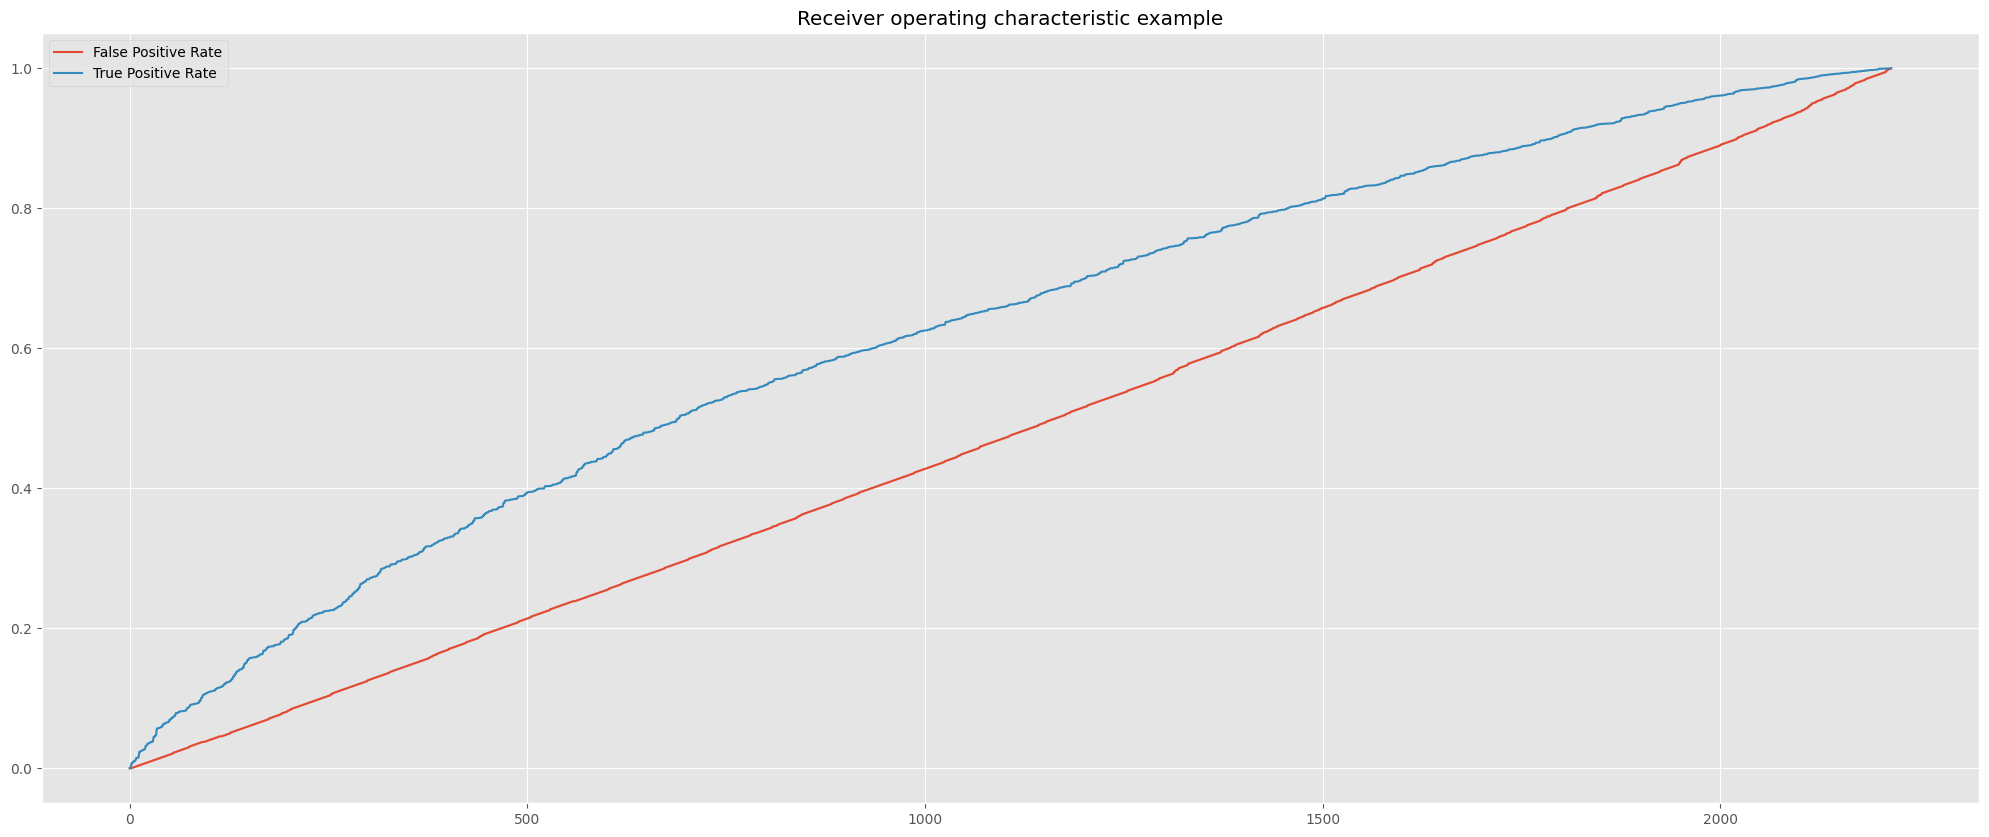

In [90]:
# Here we just plot the ROC curve usinf Sckit learn
from sklearn.metrics import roc_curve, auc

rocDF = pd.DataFrame(columns=['False Positive Rate', 'True Positive Rate'])

yActual = [i[1] for i in probPred_list]
yPred = [i[0] for i in probPred_list]

rocDF['False Positive Rate'], rocDF['True Positive Rate'], _ = roc_curve(yActual, yPred)


fig, axs = plt.subplots(1, 1, figsize=(25,10), facecolor='w', edgecolor='k')
rocDF.plot(kind='line', ax=axs, title='Receiver operating characteristic example')

In [91]:
perfMetrix.loc[round(perfMetrix['accuracy'],2) == round(perfMetrix['recall'], 2)]
# 0.089289	0.606529	0.139023	0.610272

,accuracy,precision,recall


In [92]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric

## Convert the input dataframe into RDD with dense vectors
probPred_collect = probPred.collect()

# One instance of probPred_collect looks like Row(label=0.0, probability=DenseVector([0.9018, 0.0982]))
probPred_list = [(float(i[1][0]), float(1.0-i[0])) for i in probPred_collect]

# We parallelize the list and convert it into RDD type
# so that we can use the the araUnderROC functionality provided by pySpark
predAndLabels = sc.parallelize(probPred_list)

metrics = metric(predAndLabels)
print("The ROC score is (@numTrees=500): ", metrics.areaUnderROC)

The ROC score is (@numTrees=500):  0.6408653172926663


<Axes: title={'center': 'Receiver operating characteristic example'}>

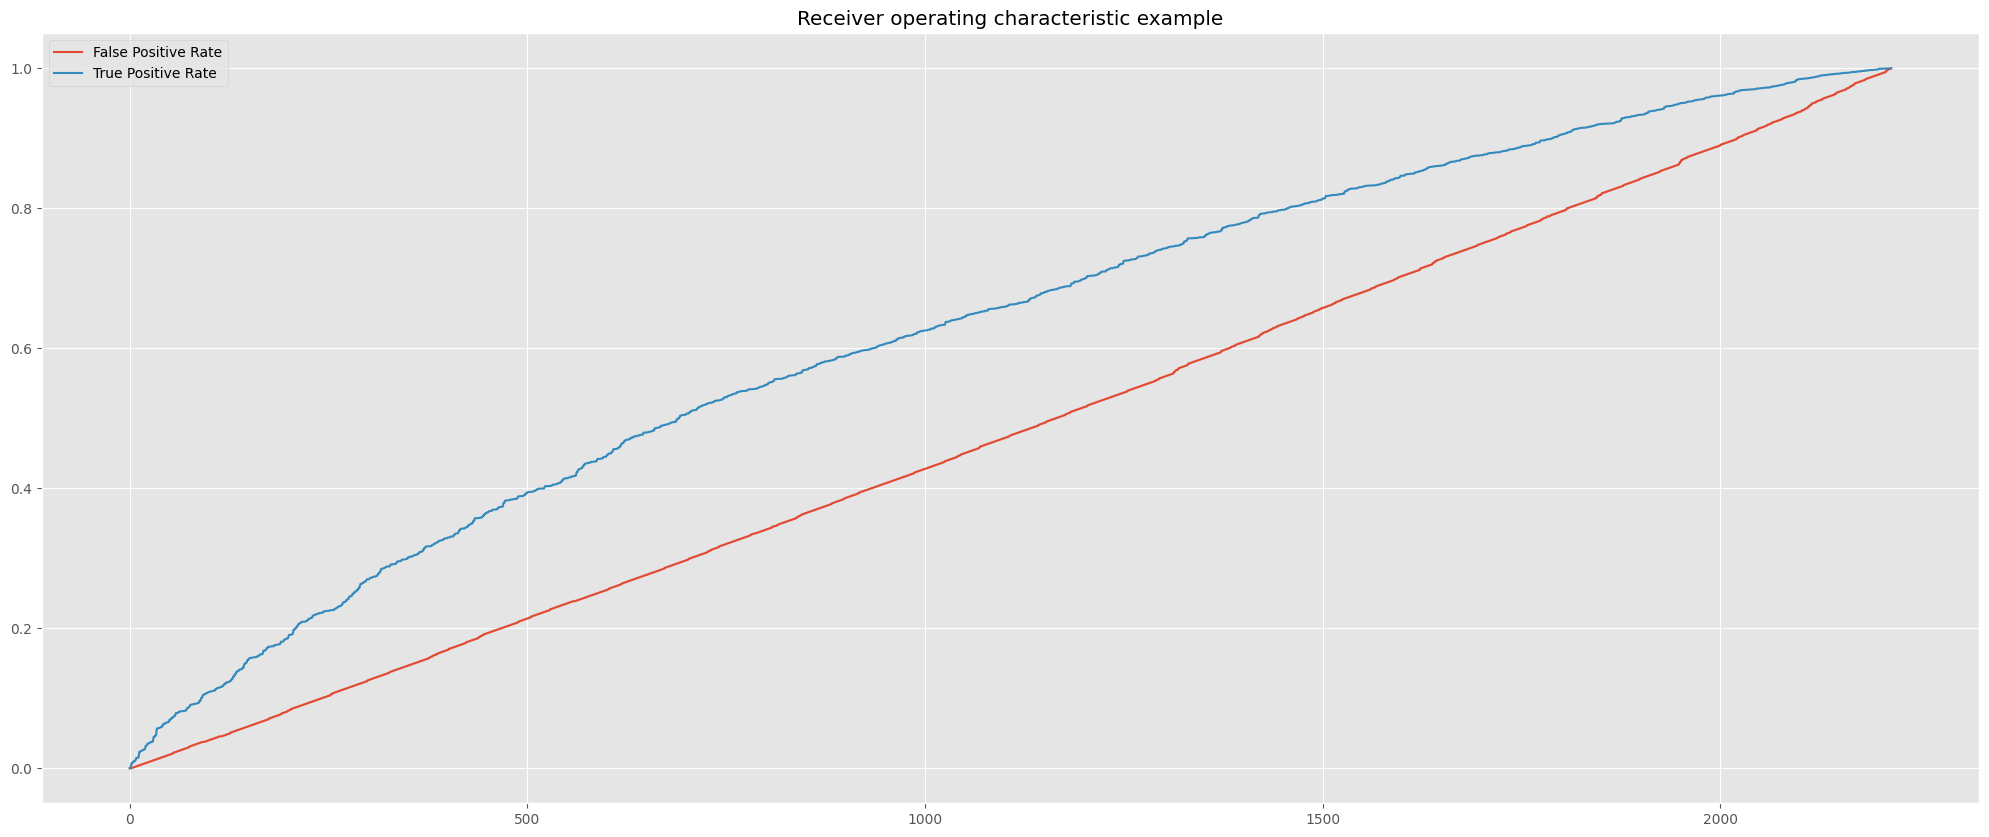

In [93]:
# Here we just plot the ROC curve usinf Sckit learn
from sklearn.metrics import roc_curve, auc

rocDF = pd.DataFrame(columns=['False Positive Rate', 'True Positive Rate'])

yActual = [i[1] for i in probPred_list]
yPred = [i[0] for i in probPred_list]

rocDF['False Positive Rate'], rocDF['True Positive Rate'], _ = roc_curve(yActual, yPred)


fig, axs = plt.subplots(1, 1, figsize=(25,10), facecolor='w', edgecolor='k')
rocDF.plot(kind='line', ax=axs, title='Receiver operating characteristic example')

In [94]:
perfMetrix.loc[round(perfMetrix['accuracy'],1) == round(perfMetrix['recall'], 1)]

#0.089289	0.606529	0.138401	0.606495

,accuracy,precision,recall
0.089890,0.568779,0.124651,0.643715
0.090090,0.582726,0.126307,0.628503
0.090290,0.594619,0.126979,0.610088
0.090490,0.606088,0.127568,0.591673
0.090691,0.619044,0.128951,0.574860
0.090891,0.631150,0.130435,0.559648


In [95]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric

## Convert the input dataframe into RDD with dense vectors
probPred_collect = probPred.collect()

# One instance of probPred_collect looks like Row(label=0.0, probability=DenseVector([0.9018, 0.0982]))
probPred_list = [(float(i[1][0]), float(1.0-i[0])) for i in probPred_collect]

# We parallelize the list and convert it into RDD type
# so that we can use the the araUnderROC functionality provided by pySpark
predAndLabels = sc.parallelize(probPred_list)

metrics = metric(predAndLabels)
print("The ROC score is (@numTrees=500): ", metrics.areaUnderROC)

The ROC score is (@numTrees=500):  0.6408878267572121


<Axes: title={'center': 'Receiver operating characteristic example'}>

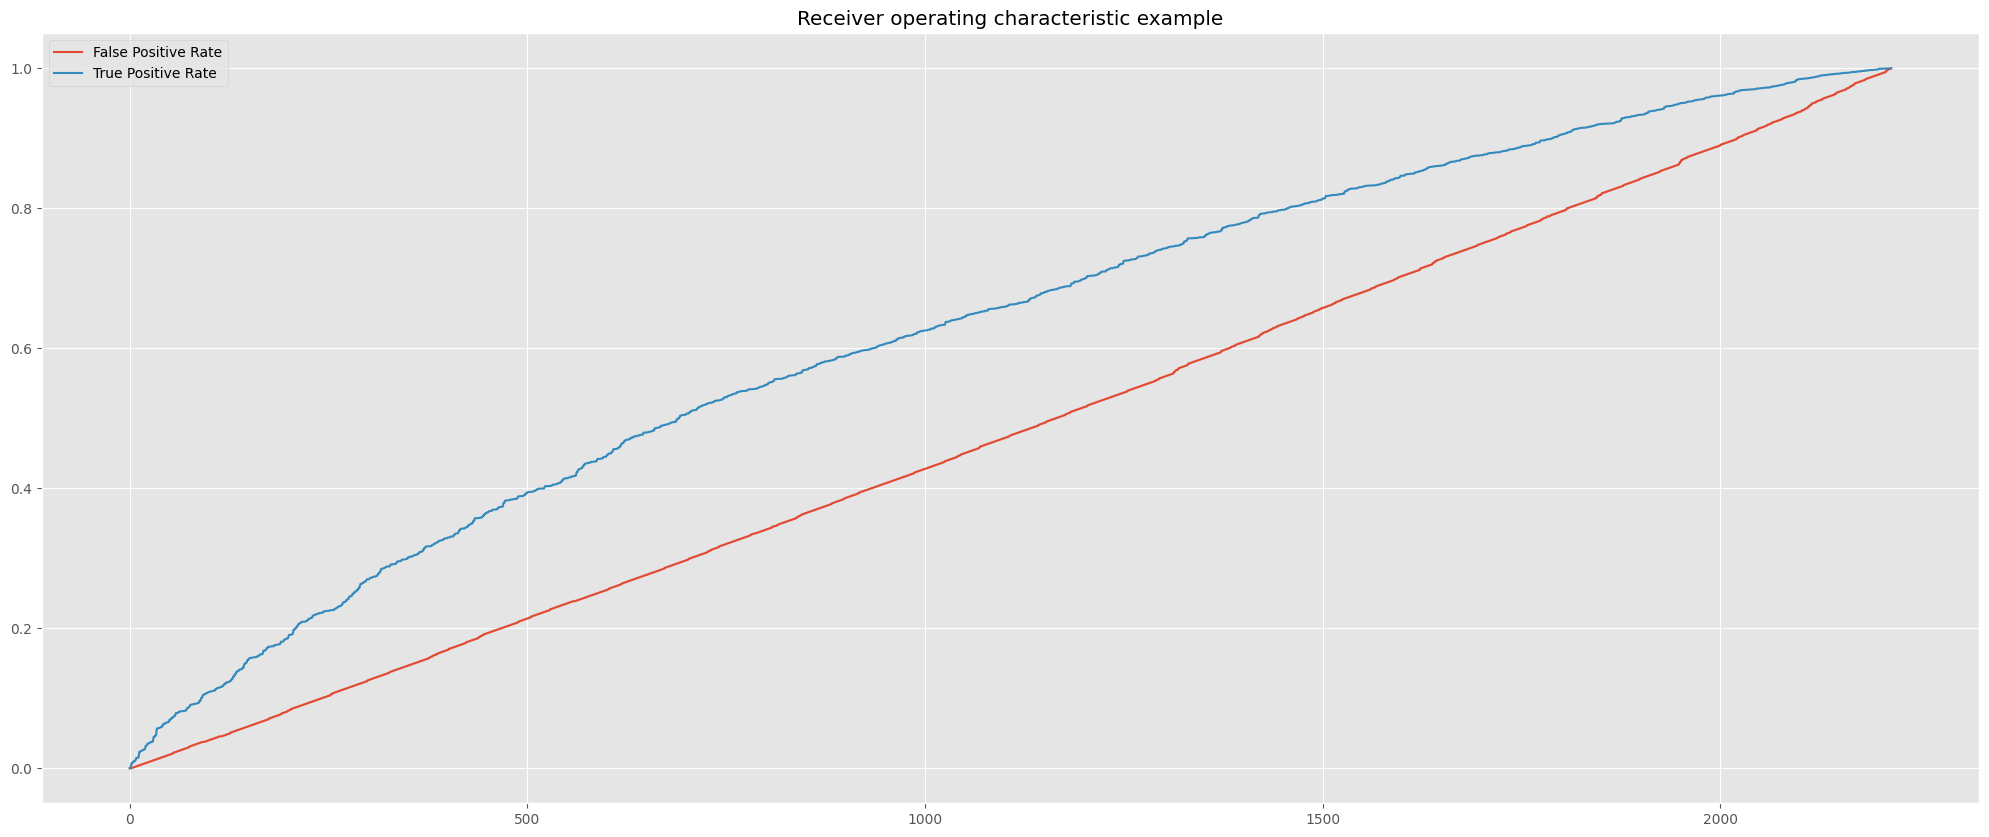

In [96]:
from sklearn.metrics import roc_curve, auc

rocDF = pd.DataFrame(columns=['False Positive Rate', 'True Positive Rate'])

yActual = [i[1] for i in probPred_list]
yPred = [i[0] for i in probPred_list]

rocDF['False Positive Rate'], rocDF['True Positive Rate'], _ = roc_curve(yActual, yPred)


fig, axs = plt.subplots(1, 1, figsize=(25,10), facecolor='w', edgecolor='k')
rocDF.plot(kind='line', ax=axs, title='Receiver operating characteristic example')